In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns
import time

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return torch.cos(t) - torch.pi/2*torch.sin(x)*torch.cos(t)

def u_exact(x, t):
    return torch.pi/2*torch.sin(x)*torch.cos(t)

def theta_exact(x, t):
    return (torch.pi/2*torch.cos(x) + (x - torch.pi/2)) * torch.cos(t)

In [3]:
def gen_data(L, t_end, n_t, n_x=5):
    "generates data in a way that mimics sensors. n_x is number of sensors, n_t is number of time points per sensor"
    x_coords = torch.linspace(0, L, n_x)
    t_times = torch.linspace(0, t_end, n_t)

    x_vals = x_coords.repeat_interleave(n_t)
    t_vals = t_times.repeat(n_x)
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals), theta_exact(x_vals, t_vals))

In [4]:
def split_train_val(val_frac, *tensors):
    "Splits the data into training and validation datasets"
    N = tensors[0].shape[0]
    perm = torch.randperm(N)
    n_val = int(N * val_frac)
    val_idx, train_idx = perm[:n_val], perm[n_val:]
    return (tuple(t[train_idx] for t in tensors),
            tuple(t[val_idx]   for t in tensors))

In [5]:
# training data generation
t_end = 2*torch.pi
t_interval = 0.1
num_sensors = 5

generated_data = gen_data(torch.pi, t_end, int(t_end/t_interval), num_sensors)
(x_gen, t_gen, f_gen, u_gen, theta_gen), (x_gen_val, t_gen_val, f_gen_val, u_gen_val, theta_gen_val) = split_train_val(0.1, *generated_data)

In [6]:
print(int(t_end/t_interval)*num_sensors)  # number of data points

310


In [7]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [9]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)
theta_normalizer = normUnitvar(theta_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
theta_norm = theta_normalizer.normalize(theta_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)
theta_val_norm = theta_normalizer.normalize(theta_gen_val)

# Stack inputs (x, t) and outputs (u, theta) into N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([u_gen, theta_gen], dim=1).to(device) # Changed to u_gen, theta_gen
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 2]
outputs_train = torch.stack([u_norm, theta_norm], dim=1).to(device)  # Shape: [N, 2] # Changed to u_norm, theta_norm
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 2]
outputs_val = torch.stack([u_val_norm, theta_val_norm], dim=1).to(device)  # Shape: [N_val, 2] # Changed to u_val_norm, theta_val_norm

batch_size = 300

validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

validation_loader = DataLoader(validation_set, batch_size=batch_size)

In [26]:
# save the normalizers to use in result file
torch.save({
    "x_mean": x_normalizer.normmean,
    "x_std": x_normalizer.normstd,
    "t_mean": t_normalizer.normmean,
    "t_std": t_normalizer.normstd,
    "u_mean": u_normalizer.normmean,
    "u_std": u_normalizer.normstd,
    "theta_mean": theta_normalizer.normmean,
    "theta_std": theta_normalizer.normstd,
}, "normalizers_L1.pt")

In [10]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_hid_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = torch.tanh(layer(x))  # Activate each layer except the output
        x = self.fc_out(x)          # Output layer
        return x

In [11]:
# Define parameters
L = torch.pi
T_end = t_end

# Set sample sizes
N_f = 10000 #2000   # collocation points in interior
N_ic = 2000 #256   # initial condition samples at t=0
N_bc = 2000 #256   # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 250

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.5159936479098971
lambda_ic = 0.8864294390105605
lambda_bc = 0.1903298187728237
lambda_physics = 0.3189466971984536

lambdas = (lambda_data, lambda_ic, lambda_bc, lambda_physics)
# echo on screen
echo_every = 75


In [12]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            # ---------------------- student exercise --------------------------------- #
            pred = model(inputs)
            loss = loss_function(pred, target)
            losses.append(loss.detach().item())
            # ---------------------- student exercise --------------------------------- #

    return np.array(losses).mean()

In [13]:
def training_loop(pinn, optimiser, trial, lambdas):    
    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()

    lambda_data, lambda_ic, lambda_bc, lambda_physics = lambdas

    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        full_pred_data_norm = pinn(inputs_train)

        # Loss for u
        u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
        target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
        loss_data_u = torch.mean(torch.abs(u_pred_data_norm - target_u_norm))

        # Loss for theta
        theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
        target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
        loss_data_theta = torch.mean(torch.abs(theta_pred_data_norm - target_theta_norm))

        # compute boundary loss
        # initial condition
        u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
        u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
        u = u_ic_denorm
        loss_initial_u = (torch.abs(u - np.pi/2*torch.sin(x_ic))).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_initial_u_t = (torch.abs(dudt - 0)).mean()
        theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
        theta = theta_ic_denorm
        loss_initial_theta = (torch.abs(theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))).mean()
        dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
        loss_initial_theta_t = (torch.abs(dthetadt - 0)).mean()

        loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

        # boundary condition left
        u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
        u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
        u = u_bc_left_denorm
        loss_bc_left_u = (torch.abs(u - 0)).mean()
        theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
        theta = theta_bc_left_denorm
        loss_bc_left_theta = (torch.abs(theta - 0)).mean()

        # boundary condition right
        u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
        u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
        u = u_bc_right_denorm
        loss_bc_right_u = (torch.abs(u - 0)).mean()
        theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
        theta = theta_bc_right_denorm
        loss_bc_right_theta = (torch.abs(theta - 0)).mean()

        loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

        #compute physics loss
        EI, rhoI, rhoA, kAG = 1, 1, 1, 1
        u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
        u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
        u_f = u_f_pred_denorm
        theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
        theta_f = theta_f_pred_denorm
        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
        dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
        d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

        
        physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
        loss_physics_1 = torch.mean(torch.abs(physics_residual_1))
        physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
        loss_physics_2 = torch.mean(torch.abs(physics_residual_2))

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())
        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            #print(f"Epoch {i}: total loss = {loss}, loss1 = {loss1}, loss2 = {loss2}, loss3 = {loss3}, loss4 = {loss4}, loss5 = {loss5}, loss6 = {loss6}, loss7 = {loss7}, loss_data_u = {loss_data_u}, loss_data_theta = {loss_data_theta}")
            print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")
        
            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()
        # Check if the trial has exceeded the maximum allowed time
        
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()

    
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss

The objective function ```objective_architecture``` optimises the architecture of the model. It is used by optuna to optimise the ```hidden_size```, ```num_layers``` and the ```learning_rate``` hyperparameters. The optimiser was also included in this optimisation, but after consistently showing Adam to be the best optimiser for this problem. These lines were then deactivated to reduce the solution space explored by optuna.

In [14]:
def objective_architecture(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    # optimiser_id = trial.suggest_categorical('optimiser', [0, 1, 2])
    # optimiser = [torch.optim.AdamW, torch.optim.Adam, torch.optim.SGD][optimiser_id]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 5e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    pinn = MLP(2,hidden_size,2, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.Adam(pinn.parameters(),lr=learning_rate)
    validation_loss = training_loop(pinn, optimiser, trial, lambdas=lambdas)

    return validation_loss

The objective function ```objective_lamdas``` uses a model with the hyperparameters found by the architecture study, then trains a model to optimise the weights of the data, initial conditions, boundary conditions and physics losses. This is an important step to get stable, regularised training, as these losses dont all share the same units, and therefore dont have the same orders of magnitude.

In [15]:
def objective_lambdas(trial_w):
    lambda_data = trial_w.suggest_float('lambda_data', 0.1, 1, log=True)
    lambda_ic = trial_w.suggest_float('lambda_ic', 0.1, 1)
    lambda_bc = trial_w.suggest_float('lambda_bc', 0.1, 1, log=True)
    lambda_physics = trial_w.suggest_float('lambda_physics', 0.1, 1)

    lambdas_suggested = (lambda_data, lambda_ic, lambda_bc, lambda_physics)

    # setup the PINN with the best architecture found
    # using global variable defined after the cell is not great practice, but cannot easily be avoided due to Optuna structure

    pinn = MLP(2,trial_archi.params['hidden_size'],2, num_hid_layers=trial_archi.params['num_layers']).to(device)   
    optimiser = torch.optim.Adam(pinn.parameters(),lr=trial_archi.params['learning_rate'])

    validation_loss = training_loop(pinn, optimiser, trial_w, lambdas=lambdas_suggested)
    
    return validation_loss

The optuna studies below first optimise the architecture, and then optimise the lambdas using those results.  

In [16]:
# This cell will first optimize the architecture, then optimize the lambdas using the best architecture found.
# Note that this will take a while (~30 minutes with reduced data) to run!
# If you have a model file, you might want to skip this and following cells and continue at the marked cell.

study_architecture = optuna.create_study(direction='minimize')
study_architecture.optimize(objective_architecture, n_trials=50)

pruned_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_archi = study_architecture.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

trial_archi = study_architecture.best_trial

n_epochs = 250

study_lambdas = optuna.create_study(direction='minimize')
study_lambdas.optimize(objective_lambdas, n_trials=50)
pruned_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials_lambdas = study_lambdas.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# summaries of both studies
print("Study architecture statistics: ")
print("  Number of finished trials: ", len(study_architecture.trials))
print("  Number of pruned trials: ", len(pruned_trials_archi))
print("  Number of complete trials: ", len(complete_trials_archi))

print("Best trial architecture:")


print("  Value: ", trial_archi.value)

print("  Params: ")
for key, value in trial_archi.params.items():
    print("    {}: {}".format(key, value))


print("Study lambdas statistics: ")
print("  Number of finished trials: ", len(study_lambdas.trials))
print("  Number of pruned trials: ", len(pruned_trials_lambdas))
print("  Number of complete trials: ", len(complete_trials_lambdas))
print("Best trial lambdas:")

trial_lambdas = study_lambdas.best_trial
print("  Value: ", trial_lambdas.value)

print("  Params: ")
for key, value in trial_lambdas.params.items():
    print("    {}: {}".format(key, value))


[I 2026-01-28 14:22:53,093] A new study created in memory with name: no-name-5c1cd145-a856-480a-b9a5-007fa1ddb9df


Epoch 0: total loss = 1.860718, Initial_u = 1.000613, Initial_u_t = 0.007244, Initial_theta = 0.215933, Initial_theta_t = 0.000091, BC_left_u = 0.059466, BC_left_theta = 0.002306, BC_right_u = 0.025309, BC_right_theta = 0.004423, Physics_1 = 0.014834, Physics_2 = 0.268259
Validation loss at epoch 0: 0.589778
Epoch 75: total loss = 1.369491, Initial_u = 0.301688, Initial_u_t = 0.052138, Initial_theta = 0.207039, Initial_theta_t = 0.001563, BC_left_u = 0.137716, BC_left_theta = 0.002955, BC_right_u = 0.128088, BC_right_theta = 0.002802, Physics_1 = 0.166713, Physics_2 = 0.308995
Validation loss at epoch 75: 0.658312
Epoch 150: total loss = 1.057969, Initial_u = 0.022608, Initial_u_t = 0.017949, Initial_theta = 0.194934, Initial_theta_t = 0.002297, BC_left_u = 0.080791, BC_left_theta = 0.006769, BC_right_u = 0.091345, BC_right_theta = 0.005149, Physics_1 = 0.285895, Physics_2 = 0.427090
Validation loss at epoch 150: 0.586685
Epoch 225: total loss = 0.987250, Initial_u = 0.025035, Initial_

[I 2026-01-28 14:23:10,639] Trial 0 finished with value: 0.5004038214683533 and parameters: {'hidden_size': 150, 'learning_rate': 0.00021886761200984366, 'num_layers': 3}. Best is trial 0 with value: 0.5004038214683533.


  Params: 
    hidden_size: 150
    learning_rate: 0.00021886761200984366
    num_layers: 3
Epoch 0: total loss = 1.893991, Initial_u = 0.987276, Initial_u_t = 0.011134, Initial_theta = 0.214250, Initial_theta_t = 0.000671, BC_left_u = 0.080275, BC_left_theta = 0.024935, BC_right_u = 0.016031, BC_right_theta = 0.008142, Physics_1 = 0.042302, Physics_2 = 0.265698
Validation loss at epoch 0: 0.642354
Epoch 75: total loss = 1.004364, Initial_u = 0.029547, Initial_u_t = 0.029243, Initial_theta = 0.202428, Initial_theta_t = 0.002680, BC_left_u = 0.104742, BC_left_theta = 0.004256, BC_right_u = 0.088190, BC_right_theta = 0.003896, Physics_1 = 0.209704, Physics_2 = 0.396988
Validation loss at epoch 75: 0.493346
Epoch 150: total loss = 0.787627, Initial_u = 0.039869, Initial_u_t = 0.013448, Initial_theta = 0.036969, Initial_theta_t = 0.047772, BC_left_u = 0.061233, BC_left_theta = 0.054551, BC_right_u = 0.076970, BC_right_theta = 0.055946, Physics_1 = 0.200437, Physics_2 = 0.334116
Validation 

[I 2026-01-28 14:23:22,432] Trial 1 finished with value: 0.23564757406711578 and parameters: {'hidden_size': 50, 'learning_rate': 0.00611381193668835, 'num_layers': 3}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 50
    learning_rate: 0.00611381193668835
    num_layers: 3
Epoch 0: total loss = 1.858202, Initial_u = 1.009862, Initial_u_t = 0.002014, Initial_theta = 0.216371, Initial_theta_t = 0.002621, BC_left_u = 0.010450, BC_left_theta = 0.009545, BC_right_u = 0.015643, BC_right_theta = 0.006808, Physics_1 = 0.009168, Physics_2 = 0.268982
Validation loss at epoch 0: 0.718625
Epoch 75: total loss = 1.026981, Initial_u = 0.052131, Initial_u_t = 0.015502, Initial_theta = 0.164940, Initial_theta_t = 0.011715, BC_left_u = 0.141424, BC_left_theta = 0.021685, BC_right_u = 0.131355, BC_right_theta = 0.014558, Physics_1 = 0.269317, Physics_2 = 0.362766
Validation loss at epoch 75: 0.574996
Epoch 150: total loss = 0.798626, Initial_u = 0.087896, Initial_u_t = 0.037583, Initial_theta = 0.048181, Initial_theta_t = 0.036481, BC_left_u = 0.114509, BC_left_theta = 0.034112, BC_right_u = 0.088709, BC_right_theta = 0.045791, Physics_1 = 0.220454, Physics_2 = 0.294537
Validation loss

[I 2026-01-28 14:23:39,393] Trial 2 finished with value: 0.3373766243457794 and parameters: {'hidden_size': 200, 'learning_rate': 0.0015591577976647123, 'num_layers': 3}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 200
    learning_rate: 0.0015591577976647123
    num_layers: 3
Epoch 0: total loss = 1.931717, Initial_u = 0.796114, Initial_u_t = 0.042291, Initial_theta = 0.221854, Initial_theta_t = 0.001322, BC_left_u = 0.285137, BC_left_theta = 0.031012, BC_right_u = 0.192624, BC_right_theta = 0.010478, Physics_1 = 0.133568, Physics_2 = 0.273601
Validation loss at epoch 0: 0.682332
Epoch 75: total loss = 1.282420, Initial_u = 0.207338, Initial_u_t = 0.057960, Initial_theta = 0.168606, Initial_theta_t = 0.011517, BC_left_u = 0.113913, BC_left_theta = 0.016135, BC_right_u = 0.115871, BC_right_theta = 0.016789, Physics_1 = 0.222946, Physics_2 = 0.331949
Validation loss at epoch 75: 0.674274
Epoch 150: total loss = 1.012110, Initial_u = 0.083774, Initial_u_t = 0.005451, Initial_theta = 0.122852, Initial_theta_t = 0.018763, BC_left_u = 0.075159, BC_left_theta = 0.019472, BC_right_u = 0.066513, BC_right_theta = 0.022641, Physics_1 = 0.212984, Physics_2 = 0.377115
Validation l

[I 2026-01-28 14:23:53,481] Trial 3 finished with value: 0.5277090668678284 and parameters: {'hidden_size': 350, 'learning_rate': 0.0003240601411682444, 'num_layers': 1}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 350
    learning_rate: 0.0003240601411682444
    num_layers: 1
Epoch 0: total loss = 1.965233, Initial_u = 1.036500, Initial_u_t = 0.026650, Initial_theta = 0.200441, Initial_theta_t = 0.004449, BC_left_u = 0.071758, BC_left_theta = 0.032070, BC_right_u = 0.022635, BC_right_theta = 0.026778, Physics_1 = 0.027065, Physics_2 = 0.267624
Validation loss at epoch 0: 0.631275
Epoch 75: total loss = 1.513289, Initial_u = 0.442585, Initial_u_t = 0.050848, Initial_theta = 0.202838, Initial_theta_t = 0.001429, BC_left_u = 0.166569, BC_left_theta = 0.005128, BC_right_u = 0.177074, BC_right_theta = 0.006093, Physics_1 = 0.101748, Physics_2 = 0.273363
Validation loss at epoch 75: 0.683069
Epoch 150: total loss = 1.338549, Initial_u = 0.267411, Initial_u_t = 0.045594, Initial_theta = 0.193275, Initial_theta_t = 0.003209, BC_left_u = 0.129588, BC_left_theta = 0.008624, BC_right_u = 0.104990, BC_right_theta = 0.009841, Physics_1 = 0.197845, Physics_2 = 0.308248
Validation l

[I 2026-01-28 14:24:06,102] Trial 4 finished with value: 0.6591081619262695 and parameters: {'hidden_size': 300, 'learning_rate': 0.00012366577685865275, 'num_layers': 1}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 300
    learning_rate: 0.00012366577685865275
    num_layers: 1
Epoch 0: total loss = 2.022590, Initial_u = 1.107777, Initial_u_t = 0.005026, Initial_theta = 0.224478, Initial_theta_t = 0.004749, BC_left_u = 0.110638, BC_left_theta = 0.008495, BC_right_u = 0.047262, BC_right_theta = 0.021763, Physics_1 = 0.030414, Physics_2 = 0.269241
Validation loss at epoch 0: 0.717881
Epoch 75: total loss = 0.957265, Initial_u = 0.058451, Initial_u_t = 0.018685, Initial_theta = 0.116670, Initial_theta_t = 0.020668, BC_left_u = 0.115480, BC_left_theta = 0.028081, BC_right_u = 0.083275, BC_right_theta = 0.028250, Physics_1 = 0.220684, Physics_2 = 0.364833
Validation loss at epoch 75: 0.531348
Epoch 150: total loss = 0.751268, Initial_u = 0.100195, Initial_u_t = 0.033259, Initial_theta = 0.030113, Initial_theta_t = 0.032150, BC_left_u = 0.089491, BC_left_theta = 0.040851, BC_right_u = 0.078484, BC_right_theta = 0.022891, Physics_1 = 0.204611, Physics_2 = 0.296803
Validation 

[I 2026-01-28 14:24:17,365] Trial 5 finished with value: 0.23735910654067993 and parameters: {'hidden_size': 150, 'learning_rate': 0.0022362753715451525, 'num_layers': 2}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 150
    learning_rate: 0.0022362753715451525
    num_layers: 2
Epoch 0: total loss = 1.853867, Initial_u = 0.950906, Initial_u_t = 0.015542, Initial_theta = 0.215836, Initial_theta_t = 0.001624, BC_left_u = 0.045568, BC_left_theta = 0.006320, BC_right_u = 0.068069, BC_right_theta = 0.009289, Physics_1 = 0.043476, Physics_2 = 0.264118
Validation loss at epoch 0: 0.604487
Epoch 75: total loss = 1.423063, Initial_u = 0.349600, Initial_u_t = 0.060991, Initial_theta = 0.209820, Initial_theta_t = 0.001642, BC_left_u = 0.139004, BC_left_theta = 0.003850, BC_right_u = 0.143838, BC_right_theta = 0.003290, Physics_1 = 0.143913, Physics_2 = 0.291979
Validation loss at epoch 75: 0.667932


[I 2026-01-28 14:24:29,854] Trial 6 pruned. 


Epoch 150: total loss = 1.106577, Initial_u = 0.051595, Initial_u_t = 0.017613, Initial_theta = 0.198782, Initial_theta_t = 0.003884, BC_left_u = 0.082995, BC_left_theta = 0.007503, BC_right_u = 0.068983, BC_right_theta = 0.005149, Physics_1 = 0.321371, Physics_2 = 0.405028
Validation loss at epoch 150: 0.621176
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0001137375144176562
    num_layers: 3
Epoch 0: total loss = 1.948356, Initial_u = 0.933813, Initial_u_t = 0.005011, Initial_theta = 0.236130, Initial_theta_t = 0.000612, BC_left_u = 0.145334, BC_left_theta = 0.051523, BC_right_u = 0.088180, BC_right_theta = 0.020134, Physics_1 = 0.036681, Physics_2 = 0.268454
Validation loss at epoch 0: 0.677188


[I 2026-01-28 14:24:34,865] Trial 7 pruned. 


Epoch 75: total loss = 1.338448, Initial_u = 0.240281, Initial_u_t = 0.059156, Initial_theta = 0.180179, Initial_theta_t = 0.007446, BC_left_u = 0.105577, BC_left_theta = 0.014273, BC_right_u = 0.106471, BC_right_theta = 0.015084, Physics_1 = 0.218922, Physics_2 = 0.339713
Validation loss at epoch 75: 0.692250
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.000260086578076842
    num_layers: 1
Epoch 0: total loss = 1.853697, Initial_u = 0.996215, Initial_u_t = 0.003629, Initial_theta = 0.214580, Initial_theta_t = 0.001541, BC_left_u = 0.006459, BC_left_theta = 0.008444, BC_right_u = 0.017012, BC_right_theta = 0.013101, Physics_1 = 0.017332, Physics_2 = 0.268589
Validation loss at epoch 0: 1.795771


[I 2026-01-28 14:24:42,999] Trial 8 pruned. 


Epoch 75: total loss = 2.401809, Initial_u = 0.751726, Initial_u_t = 0.000000, Initial_theta = 0.248804, Initial_theta_t = 0.000000, BC_left_u = 0.285584, BC_left_theta = 0.189214, BC_right_u = 0.285593, BC_right_theta = 0.189207, Physics_1 = 0.189206, Physics_2 = 0.266696
Validation loss at epoch 75: 0.818135
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.03230323155097191
    num_layers: 3
Epoch 0: total loss = 1.867385, Initial_u = 0.970346, Initial_u_t = 0.002839, Initial_theta = 0.224420, Initial_theta_t = 0.002836, BC_left_u = 0.014628, BC_left_theta = 0.010842, BC_right_u = 0.060613, BC_right_theta = 0.024868, Physics_1 = 0.020015, Physics_2 = 0.267699
Validation loss at epoch 0: 3.204242
Epoch 75: total loss = 1.036762, Initial_u = 0.309616, Initial_u_t = 0.019797, Initial_theta = 0.113690, Initial_theta_t = 0.009441, BC_left_u = 0.087099, BC_left_theta = 0.039803, BC_right_u = 0.145357, BC_right_theta = 0.044872, Physics_1 = 0.367112, Physics_2 = 0.628184
Validat

[I 2026-01-28 14:25:09,939] Trial 9 finished with value: 0.6599057912826538 and parameters: {'hidden_size': 400, 'learning_rate': 0.01634171254183588, 'num_layers': 2}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 400
    learning_rate: 0.01634171254183588
    num_layers: 2
Epoch 0: total loss = 1.795555, Initial_u = 0.865755, Initial_u_t = 0.006129, Initial_theta = 0.219395, Initial_theta_t = 0.000631, BC_left_u = 0.070748, BC_left_theta = 0.016525, BC_right_u = 0.107824, BC_right_theta = 0.004295, Physics_1 = 0.022728, Physics_2 = 0.269948
Validation loss at epoch 0: 0.715806
Epoch 75: total loss = 1.030189, Initial_u = 0.084974, Initial_u_t = 0.033994, Initial_theta = 0.154124, Initial_theta_t = 0.009676, BC_left_u = 0.068802, BC_left_theta = 0.015869, BC_right_u = 0.092081, BC_right_theta = 0.022850, Physics_1 = 0.198329, Physics_2 = 0.412816
Validation loss at epoch 75: 0.530546
Epoch 150: total loss = 0.728695, Initial_u = 0.064727, Initial_u_t = 0.018044, Initial_theta = 0.032484, Initial_theta_t = 0.036900, BC_left_u = 0.073830, BC_left_theta = 0.034080, BC_right_u = 0.073000, BC_right_theta = 0.030079, Physics_1 = 0.236876, Physics_2 = 0.320399
Validation los

[I 2026-01-28 14:25:19,949] Trial 10 finished with value: 0.2618624269962311 and parameters: {'hidden_size': 50, 'learning_rate': 0.006794153977476682, 'num_layers': 2}. Best is trial 1 with value: 0.23564757406711578.


  Params: 
    hidden_size: 50
    learning_rate: 0.006794153977476682
    num_layers: 2
Epoch 0: total loss = 1.865943, Initial_u = 0.976392, Initial_u_t = 0.008838, Initial_theta = 0.223098, Initial_theta_t = 0.001533, BC_left_u = 0.034698, BC_left_theta = 0.007108, BC_right_u = 0.056354, BC_right_theta = 0.005094, Physics_1 = 0.030982, Physics_2 = 0.271981
Validation loss at epoch 0: 0.605309


[I 2026-01-28 14:25:22,981] Trial 11 pruned. 


Epoch 75: total loss = 1.069793, Initial_u = 0.048496, Initial_u_t = 0.022171, Initial_theta = 0.199757, Initial_theta_t = 0.002598, BC_left_u = 0.079413, BC_left_theta = 0.006921, BC_right_u = 0.093576, BC_right_theta = 0.005845, Physics_1 = 0.223632, Physics_2 = 0.405968
Validation loss at epoch 75: 0.591550
 (Pruned) Params: 
    hidden_size: 50
    learning_rate: 0.0019122804712077505
    num_layers: 2
Epoch 0: total loss = 1.876766, Initial_u = 0.944241, Initial_u_t = 0.011706, Initial_theta = 0.211698, Initial_theta_t = 0.002231, BC_left_u = 0.021543, BC_left_theta = 0.014225, BC_right_u = 0.155230, BC_right_theta = 0.009960, Physics_1 = 0.052429, Physics_2 = 0.268603
Validation loss at epoch 0: 0.932516
Epoch 75: total loss = 1.024491, Initial_u = 0.262206, Initial_u_t = 0.026726, Initial_theta = 0.079055, Initial_theta_t = 0.029887, BC_left_u = 0.092853, BC_left_theta = 0.035885, BC_right_u = 0.099987, BC_right_theta = 0.037286, Physics_1 = 0.174253, Physics_2 = 0.280207
Valida

[I 2026-01-28 14:25:34,399] Trial 12 finished with value: 0.207189679145813 and parameters: {'hidden_size': 150, 'learning_rate': 0.004030807824678802, 'num_layers': 2}. Best is trial 12 with value: 0.207189679145813.


  Params: 
    hidden_size: 150
    learning_rate: 0.004030807824678802
    num_layers: 2
Epoch 0: total loss = 1.881281, Initial_u = 0.980923, Initial_u_t = 0.003939, Initial_theta = 0.215458, Initial_theta_t = 0.002597, BC_left_u = 0.015465, BC_left_theta = 0.019329, BC_right_u = 0.080419, BC_right_theta = 0.010160, Physics_1 = 0.042214, Physics_2 = 0.269813
Validation loss at epoch 0: 0.836371


[I 2026-01-28 14:25:37,356] Trial 13 pruned. 


Epoch 75: total loss = 0.992897, Initial_u = 0.053767, Initial_u_t = 0.094312, Initial_theta = 0.091541, Initial_theta_t = 0.026272, BC_left_u = 0.141676, BC_left_theta = 0.031756, BC_right_u = 0.078946, BC_right_theta = 0.032222, Physics_1 = 0.163710, Physics_2 = 0.359762
Validation loss at epoch 75: 0.555507
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.005213860815604642
    num_layers: 2
Epoch 0: total loss = 1.831560, Initial_u = 0.963606, Initial_u_t = 0.003492, Initial_theta = 0.213423, Initial_theta_t = 0.000168, BC_left_u = 0.018495, BC_left_theta = 0.008677, BC_right_u = 0.040677, BC_right_theta = 0.008805, Physics_1 = 0.023618, Physics_2 = 0.266720
Validation loss at epoch 0: 2.684482
Epoch 75: total loss = 1.244093, Initial_u = 0.280653, Initial_u_t = 0.034856, Initial_theta = 0.170723, Initial_theta_t = 0.002339, BC_left_u = 0.263879, BC_left_theta = 0.012431, BC_right_u = 0.206877, BC_right_theta = 0.018673, Physics_1 = 0.179840, Physics_2 = 0.376996
Valida

[I 2026-01-28 14:26:22,044] Trial 14 finished with value: 0.208383247256279 and parameters: {'hidden_size': 500, 'learning_rate': 0.007415378146933521, 'num_layers': 3}. Best is trial 12 with value: 0.207189679145813.


  Params: 
    hidden_size: 500
    learning_rate: 0.007415378146933521
    num_layers: 3
Epoch 0: total loss = 1.983129, Initial_u = 1.096853, Initial_u_t = 0.008298, Initial_theta = 0.222011, Initial_theta_t = 0.001550, BC_left_u = 0.028663, BC_left_theta = 0.006386, BC_right_u = 0.089965, BC_right_theta = 0.014566, Physics_1 = 0.022455, Physics_2 = 0.268861
Validation loss at epoch 0: 0.924583


[I 2026-01-28 14:26:31,785] Trial 15 pruned. 


Epoch 75: total loss = 1.035280, Initial_u = 0.121481, Initial_u_t = 0.032864, Initial_theta = 0.078820, Initial_theta_t = 0.028940, BC_left_u = 0.160303, BC_left_theta = 0.034904, BC_right_u = 0.110316, BC_right_theta = 0.035009, Physics_1 = 0.191254, Physics_2 = 0.358609
Validation loss at epoch 75: 0.638691
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.0006886283616894326
    num_layers: 2
Epoch 0: total loss = 1.836148, Initial_u = 0.954249, Initial_u_t = 0.002414, Initial_theta = 0.216369, Initial_theta_t = 0.001248, BC_left_u = 0.075298, BC_left_theta = 0.013913, BC_right_u = 0.029245, BC_right_theta = 0.005514, Physics_1 = 0.013241, Physics_2 = 0.270898
Validation loss at epoch 0: 2.168058
Epoch 75: total loss = 1.186930, Initial_u = 0.145331, Initial_u_t = 0.029535, Initial_theta = 0.064933, Initial_theta_t = 0.008107, BC_left_u = 0.169111, BC_left_theta = 0.073377, BC_right_u = 0.192148, BC_right_theta = 0.068675, Physics_1 = 0.332352, Physics_2 = 0.760580
Valid

[I 2026-01-28 14:27:08,903] Trial 16 pruned. 


Epoch 225: total loss = 1.040249, Initial_u = 0.231529, Initial_u_t = 0.031793, Initial_theta = 0.045359, Initial_theta_t = 0.012859, BC_left_u = 0.127270, BC_left_theta = 0.052027, BC_right_u = 0.065129, BC_right_theta = 0.056343, Physics_1 = 0.358286, Physics_2 = 0.581042
Validation loss at epoch 225: 0.561378
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.015758113020945434
    num_layers: 3
Epoch 0: total loss = 1.927463, Initial_u = 0.907869, Initial_u_t = 0.020995, Initial_theta = 0.212714, Initial_theta_t = 0.007834, BC_left_u = 0.176017, BC_left_theta = 0.017261, BC_right_u = 0.091515, BC_right_theta = 0.028544, Physics_1 = 0.070892, Physics_2 = 0.267930
Validation loss at epoch 0: 6.700896


[I 2026-01-28 14:27:14,871] Trial 17 pruned. 


Epoch 75: total loss = 2.757818, Initial_u = 0.744026, Initial_u_t = 0.027704, Initial_theta = 0.289232, Initial_theta_t = 0.003383, BC_left_u = 0.289996, BC_left_theta = 0.252133, BC_right_u = 0.342889, BC_right_theta = 0.290115, Physics_1 = 0.324657, Physics_2 = 0.480307
Validation loss at epoch 75: 1.253088
 (Pruned) Params: 
    hidden_size: 500
    learning_rate: 0.04997665525500235
    num_layers: 1
Epoch 0: total loss = 1.889760, Initial_u = 0.985786, Initial_u_t = 0.003499, Initial_theta = 0.216448, Initial_theta_t = 0.002380, BC_left_u = 0.060061, BC_left_theta = 0.007411, BC_right_u = 0.081819, BC_right_theta = 0.009340, Physics_1 = 0.045962, Physics_2 = 0.269783
Validation loss at epoch 0: 1.048525
Epoch 75: total loss = 0.829073, Initial_u = 0.084246, Initial_u_t = 0.012526, Initial_theta = 0.038693, Initial_theta_t = 0.039539, BC_left_u = 0.100623, BC_left_theta = 0.054472, BC_right_u = 0.204253, BC_right_theta = 0.039134, Physics_1 = 0.211359, Physics_2 = 0.293263
Validat

[I 2026-01-28 14:27:28,130] Trial 18 finished with value: 0.09994225203990936 and parameters: {'hidden_size': 200, 'learning_rate': 0.003615602881620137, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 200
    learning_rate: 0.003615602881620137
    num_layers: 2
Epoch 0: total loss = 1.835431, Initial_u = 0.894073, Initial_u_t = 0.008198, Initial_theta = 0.208406, Initial_theta_t = 0.001983, BC_left_u = 0.147951, BC_left_theta = 0.017192, BC_right_u = 0.045425, BC_right_theta = 0.008224, Physics_1 = 0.049248, Physics_2 = 0.267671
Validation loss at epoch 0: 0.722303


[I 2026-01-28 14:27:32,183] Trial 19 pruned. 


Epoch 75: total loss = 1.074565, Initial_u = 0.062423, Initial_u_t = 0.024041, Initial_theta = 0.159221, Initial_theta_t = 0.013584, BC_left_u = 0.096081, BC_left_theta = 0.015458, BC_right_u = 0.090546, BC_right_theta = 0.015686, Physics_1 = 0.234059, Physics_2 = 0.410126
Validation loss at epoch 75: 0.599984
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0009628902516206931
    num_layers: 2
Epoch 0: total loss = 1.934787, Initial_u = 1.062354, Initial_u_t = 0.004727, Initial_theta = 0.215387, Initial_theta_t = 0.005409, BC_left_u = 0.011027, BC_left_theta = 0.010868, BC_right_u = 0.038752, BC_right_theta = 0.014111, Physics_1 = 0.023914, Physics_2 = 0.266822
Validation loss at epoch 0: 0.965707
Epoch 75: total loss = 0.835036, Initial_u = 0.045690, Initial_u_t = 0.020630, Initial_theta = 0.048137, Initial_theta_t = 0.039607, BC_left_u = 0.116792, BC_left_theta = 0.038924, BC_right_u = 0.083508, BC_right_theta = 0.034516, Physics_1 = 0.204553, Physics_2 = 0.327212
Valid

[I 2026-01-28 14:27:45,414] Trial 20 finished with value: 0.12788702547550201 and parameters: {'hidden_size': 200, 'learning_rate': 0.003146602025864781, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 200
    learning_rate: 0.003146602025864781
    num_layers: 2
Epoch 0: total loss = 2.048681, Initial_u = 1.112868, Initial_u_t = 0.017677, Initial_theta = 0.214257, Initial_theta_t = 0.003308, BC_left_u = 0.122821, BC_left_theta = 0.013103, BC_right_u = 0.058857, BC_right_theta = 0.014714, Physics_1 = 0.067759, Physics_2 = 0.268947
Validation loss at epoch 0: 0.914785
Epoch 75: total loss = 0.825033, Initial_u = 0.068720, Initial_u_t = 0.019763, Initial_theta = 0.051055, Initial_theta_t = 0.034000, BC_left_u = 0.128623, BC_left_theta = 0.046071, BC_right_u = 0.069653, BC_right_theta = 0.039809, Physics_1 = 0.180220, Physics_2 = 0.312160
Validation loss at epoch 75: 0.442924
Epoch 150: total loss = 0.495380, Initial_u = 0.062566, Initial_u_t = 0.046979, Initial_theta = 0.031510, Initial_theta_t = 0.011590, BC_left_u = 0.079787, BC_left_theta = 0.017437, BC_right_u = 0.146900, BC_right_theta = 0.024446, Physics_1 = 0.219169, Physics_2 = 0.186427
Validation lo

[I 2026-01-28 14:27:58,606] Trial 21 finished with value: 0.1104484423995018 and parameters: {'hidden_size': 200, 'learning_rate': 0.0032423928555215245, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 200
    learning_rate: 0.0032423928555215245
    num_layers: 2
Epoch 0: total loss = 2.036063, Initial_u = 1.100404, Initial_u_t = 0.009171, Initial_theta = 0.217216, Initial_theta_t = 0.005153, BC_left_u = 0.089424, BC_left_theta = 0.023160, BC_right_u = 0.114695, BC_right_theta = 0.006708, Physics_1 = 0.051361, Physics_2 = 0.268067
Validation loss at epoch 0: 1.089716


[I 2026-01-28 14:28:03,312] Trial 22 pruned. 


Epoch 75: total loss = 0.877277, Initial_u = 0.041204, Initial_u_t = 0.045449, Initial_theta = 0.059360, Initial_theta_t = 0.023910, BC_left_u = 0.074832, BC_left_theta = 0.038843, BC_right_u = 0.072314, BC_right_theta = 0.037772, Physics_1 = 0.156017, Physics_2 = 0.378296
Validation loss at epoch 75: 0.513200
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.0029709502616664715
    num_layers: 2
Epoch 0: total loss = 1.890640, Initial_u = 1.007429, Initial_u_t = 0.001126, Initial_theta = 0.221106, Initial_theta_t = 0.005276, BC_left_u = 0.030714, BC_left_theta = 0.012279, BC_right_u = 0.029245, BC_right_theta = 0.014539, Physics_1 = 0.024963, Physics_2 = 0.268295
Validation loss at epoch 0: 1.849359
Epoch 75: total loss = 0.722587, Initial_u = 0.166873, Initial_u_t = 0.039147, Initial_theta = 0.056643, Initial_theta_t = 0.024046, BC_left_u = 0.107082, BC_left_theta = 0.023904, BC_right_u = 0.141196, BC_right_theta = 0.037218, Physics_1 = 0.258413, Physics_2 = 0.322872
Valid

[I 2026-01-28 14:28:16,594] Trial 23 finished with value: 0.2190798968076706 and parameters: {'hidden_size': 200, 'learning_rate': 0.013018237173280359, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 200
    learning_rate: 0.013018237173280359
    num_layers: 2
Epoch 0: total loss = 1.884306, Initial_u = 0.979803, Initial_u_t = 0.004405, Initial_theta = 0.220028, Initial_theta_t = 0.005442, BC_left_u = 0.019194, BC_left_theta = 0.006610, BC_right_u = 0.104514, BC_right_theta = 0.009125, Physics_1 = 0.042089, Physics_2 = 0.268826
Validation loss at epoch 0: 0.721314


[I 2026-01-28 14:28:21,347] Trial 24 pruned. 


Epoch 75: total loss = 1.112098, Initial_u = 0.063204, Initial_u_t = 0.023957, Initial_theta = 0.159457, Initial_theta_t = 0.013228, BC_left_u = 0.127365, BC_left_theta = 0.027395, BC_right_u = 0.117434, BC_right_theta = 0.021029, Physics_1 = 0.208618, Physics_2 = 0.415997
Validation loss at epoch 75: 0.590167
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.000905867521234621
    num_layers: 2
Epoch 0: total loss = 1.900095, Initial_u = 1.009519, Initial_u_t = 0.002854, Initial_theta = 0.223599, Initial_theta_t = 0.002635, BC_left_u = 0.059686, BC_left_theta = 0.016154, BC_right_u = 0.049488, BC_right_theta = 0.005408, Physics_1 = 0.040275, Physics_2 = 0.261225
Validation loss at epoch 0: 0.721719


[I 2026-01-28 14:28:23,796] Trial 25 pruned. 


Epoch 75: total loss = 1.008934, Initial_u = 0.068421, Initial_u_t = 0.022849, Initial_theta = 0.131108, Initial_theta_t = 0.017950, BC_left_u = 0.078003, BC_left_theta = 0.021727, BC_right_u = 0.072789, BC_right_theta = 0.017211, Physics_1 = 0.193140, Physics_2 = 0.388039
Validation loss at epoch 75: 0.589810
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.0036571725427992285
    num_layers: 1
Epoch 0: total loss = 1.896181, Initial_u = 0.975270, Initial_u_t = 0.003000, Initial_theta = 0.208541, Initial_theta_t = 0.003442, BC_left_u = 0.100400, BC_left_theta = 0.004238, BC_right_u = 0.085904, BC_right_theta = 0.017883, Physics_1 = 0.050582, Physics_2 = 0.266942
Validation loss at epoch 0: 0.725719


[I 2026-01-28 14:28:27,787] Trial 26 pruned. 


Epoch 75: total loss = 1.018185, Initial_u = 0.053511, Initial_u_t = 0.023672, Initial_theta = 0.121983, Initial_theta_t = 0.017838, BC_left_u = 0.105843, BC_left_theta = 0.020128, BC_right_u = 0.092546, BC_right_theta = 0.024859, Physics_1 = 0.216350, Physics_2 = 0.432550
Validation loss at epoch 75: 0.552469
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.0013774735995642838
    num_layers: 2
Epoch 0: total loss = 1.838438, Initial_u = 0.994330, Initial_u_t = 0.003005, Initial_theta = 0.213555, Initial_theta_t = 0.002302, BC_left_u = 0.022035, BC_left_theta = 0.004200, BC_right_u = 0.001187, BC_right_theta = 0.010652, Physics_1 = 0.012908, Physics_2 = 0.264637
Validation loss at epoch 0: 2.426952
Epoch 75: total loss = 1.159865, Initial_u = 0.271940, Initial_u_t = 0.031500, Initial_theta = 0.193264, Initial_theta_t = 0.003546, BC_left_u = 0.162841, BC_left_theta = 0.054722, BC_right_u = 0.270807, BC_right_theta = 0.037427, Physics_1 = 0.231423, Physics_2 = 0.323089
Valid

[I 2026-01-28 14:28:47,212] Trial 27 finished with value: 0.2626798748970032 and parameters: {'hidden_size': 300, 'learning_rate': 0.010305057921194927, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 300
    learning_rate: 0.010305057921194927
    num_layers: 2
Epoch 0: total loss = 1.959758, Initial_u = 1.079810, Initial_u_t = 0.009803, Initial_theta = 0.213680, Initial_theta_t = 0.001515, BC_left_u = 0.050846, BC_left_theta = 0.020650, BC_right_u = 0.058074, BC_right_theta = 0.003395, Physics_1 = 0.008972, Physics_2 = 0.270515
Validation loss at epoch 0: 0.606972


[I 2026-01-28 14:28:49,811] Trial 28 pruned. 


Epoch 75: total loss = 1.425443, Initial_u = 0.329465, Initial_u_t = 0.076646, Initial_theta = 0.187694, Initial_theta_t = 0.005768, BC_left_u = 0.153114, BC_left_theta = 0.012448, BC_right_u = 0.117305, BC_right_theta = 0.010502, Physics_1 = 0.167152, Physics_2 = 0.286878
Validation loss at epoch 75: 0.687122
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.0005133885174852336
    num_layers: 1
Epoch 0: total loss = 1.881819, Initial_u = 0.957789, Initial_u_t = 0.013166, Initial_theta = 0.221122, Initial_theta_t = 0.000854, BC_left_u = 0.066382, BC_left_theta = 0.025083, BC_right_u = 0.061442, BC_right_theta = 0.001094, Physics_1 = 0.053436, Physics_2 = 0.268032
Validation loss at epoch 0: 0.660703


[I 2026-01-28 14:28:52,802] Trial 29 pruned. 


Epoch 75: total loss = 1.038165, Initial_u = 0.074116, Initial_u_t = 0.019936, Initial_theta = 0.158369, Initial_theta_t = 0.011204, BC_left_u = 0.096695, BC_left_theta = 0.017626, BC_right_u = 0.154323, BC_right_theta = 0.013282, Physics_1 = 0.254776, Physics_2 = 0.358173
Validation loss at epoch 75: 0.512900
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.0026094726834919773
    num_layers: 2
Epoch 0: total loss = 1.847113, Initial_u = 0.892110, Initial_u_t = 0.009078, Initial_theta = 0.218590, Initial_theta_t = 0.002387, BC_left_u = 0.020525, BC_left_theta = 0.014841, BC_right_u = 0.171307, BC_right_theta = 0.011415, Physics_1 = 0.063798, Physics_2 = 0.267948
Validation loss at epoch 0: 1.611626
Epoch 75: total loss = 1.190224, Initial_u = 0.412403, Initial_u_t = 0.008932, Initial_theta = 0.216278, Initial_theta_t = 0.000280, BC_left_u = 0.101893, BC_left_theta = 0.011356, BC_right_u = 0.130281, BC_right_theta = 0.026179, Physics_1 = 0.240824, Physics_2 = 0.319888
Valid

[I 2026-01-28 14:29:03,368] Trial 30 pruned. 


Epoch 225: total loss = 1.181604, Initial_u = 0.424003, Initial_u_t = 0.007574, Initial_theta = 0.213862, Initial_theta_t = 0.001436, BC_left_u = 0.189150, BC_left_theta = 0.019850, BC_right_u = 0.169031, BC_right_theta = 0.034971, Physics_1 = 0.292531, Physics_2 = 0.366892
Validation loss at epoch 225: 0.422390
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.024229865288252554
    num_layers: 2
Epoch 0: total loss = 1.830608, Initial_u = 0.968881, Initial_u_t = 0.014246, Initial_theta = 0.209863, Initial_theta_t = 0.001680, BC_left_u = 0.025262, BC_left_theta = 0.008403, BC_right_u = 0.004121, BC_right_theta = 0.011732, Physics_1 = 0.018001, Physics_2 = 0.270081
Validation loss at epoch 0: 1.010448
Epoch 75: total loss = 1.076427, Initial_u = 0.145039, Initial_u_t = 0.083920, Initial_theta = 0.112234, Initial_theta_t = 0.019548, BC_left_u = 0.220055, BC_left_theta = 0.028080, BC_right_u = 0.085058, BC_right_theta = 0.034955, Physics_1 = 0.206236, Physics_2 = 0.317327
Vali

[I 2026-01-28 14:29:15,201] Trial 31 finished with value: 0.12458867579698563 and parameters: {'hidden_size': 150, 'learning_rate': 0.0042075666979011234, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 150
    learning_rate: 0.0042075666979011234
    num_layers: 2
Epoch 0: total loss = 1.775374, Initial_u = 0.830463, Initial_u_t = 0.012455, Initial_theta = 0.209175, Initial_theta_t = 0.000846, BC_left_u = 0.132669, BC_left_theta = 0.010873, BC_right_u = 0.071297, BC_right_theta = 0.022092, Physics_1 = 0.019065, Physics_2 = 0.267965
Validation loss at epoch 0: 1.319327


[I 2026-01-28 14:29:19,244] Trial 32 pruned. 


Epoch 75: total loss = 0.975515, Initial_u = 0.107636, Initial_u_t = 0.087023, Initial_theta = 0.075635, Initial_theta_t = 0.028951, BC_left_u = 0.104978, BC_left_theta = 0.037290, BC_right_u = 0.087666, BC_right_theta = 0.033887, Physics_1 = 0.173245, Physics_2 = 0.310940
Validation loss at epoch 75: 0.500284
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.004286488754123656
    num_layers: 2
Epoch 0: total loss = 1.924434, Initial_u = 0.965934, Initial_u_t = 0.012498, Initial_theta = 0.208089, Initial_theta_t = 0.001173, BC_left_u = 0.079726, BC_left_theta = 0.002855, BC_right_u = 0.149684, BC_right_theta = 0.023972, Physics_1 = 0.085428, Physics_2 = 0.263313
Validation loss at epoch 0: 1.765519
Epoch 75: total loss = 0.835738, Initial_u = 0.196783, Initial_u_t = 0.022621, Initial_theta = 0.046035, Initial_theta_t = 0.012402, BC_left_u = 0.095773, BC_left_theta = 0.077673, BC_right_u = 0.159985, BC_right_theta = 0.055332, Physics_1 = 0.291672, Physics_2 = 0.319246
Valida

[I 2026-01-28 14:29:34,771] Trial 33 finished with value: 0.18621745705604553 and parameters: {'hidden_size': 250, 'learning_rate': 0.008741966394301956, 'num_layers': 2}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 250
    learning_rate: 0.008741966394301956
    num_layers: 2
Epoch 0: total loss = 1.881099, Initial_u = 0.960664, Initial_u_t = 0.018669, Initial_theta = 0.217833, Initial_theta_t = 0.001358, BC_left_u = 0.048019, BC_left_theta = 0.005722, BC_right_u = 0.105684, BC_right_theta = 0.011511, Physics_1 = 0.019326, Physics_2 = 0.270669
Validation loss at epoch 0: 0.778267


[I 2026-01-28 14:29:38,773] Trial 34 pruned. 


Epoch 75: total loss = 1.012634, Initial_u = 0.084787, Initial_u_t = 0.010207, Initial_theta = 0.113249, Initial_theta_t = 0.020189, BC_left_u = 0.076597, BC_left_theta = 0.025331, BC_right_u = 0.096824, BC_right_theta = 0.025510, Physics_1 = 0.200694, Physics_2 = 0.412513
Validation loss at epoch 75: 0.572523
 (Pruned) Params: 
    hidden_size: 200
    learning_rate: 0.00138572907569427
    num_layers: 2
Epoch 0: total loss = 1.982117, Initial_u = 1.084701, Initial_u_t = 0.003220, Initial_theta = 0.214355, Initial_theta_t = 0.000624, BC_left_u = 0.077274, BC_left_theta = 0.007483, BC_right_u = 0.131114, BC_right_theta = 0.003375, Physics_1 = 0.022773, Physics_2 = 0.266852
Validation loss at epoch 0: 0.985268
Epoch 75: total loss = 0.727516, Initial_u = 0.113116, Initial_u_t = 0.020371, Initial_theta = 0.059562, Initial_theta_t = 0.009679, BC_left_u = 0.135040, BC_left_theta = 0.047276, BC_right_u = 0.056725, BC_right_theta = 0.026323, Physics_1 = 0.239379, Physics_2 = 0.351404
Validat

[I 2026-01-28 14:29:53,442] Trial 35 finished with value: 0.11078662425279617 and parameters: {'hidden_size': 150, 'learning_rate': 0.00533889327954673, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 150
    learning_rate: 0.00533889327954673
    num_layers: 3
Epoch 0: total loss = 1.961355, Initial_u = 1.035555, Initial_u_t = 0.009102, Initial_theta = 0.218890, Initial_theta_t = 0.001512, BC_left_u = 0.030540, BC_left_theta = 0.005518, BC_right_u = 0.173093, BC_right_theta = 0.007126, Physics_1 = 0.064576, Physics_2 = 0.266978
Validation loss at epoch 0: 0.713859


[I 2026-01-28 14:29:57,071] Trial 36 pruned. 


Epoch 75: total loss = 1.119649, Initial_u = 0.125637, Initial_u_t = 0.087995, Initial_theta = 0.153369, Initial_theta_t = 0.013013, BC_left_u = 0.148898, BC_left_theta = 0.018980, BC_right_u = 0.133296, BC_right_theta = 0.025937, Physics_1 = 0.211490, Physics_2 = 0.325249
Validation loss at epoch 75: 0.528071
 (Pruned) Params: 
    hidden_size: 100
    learning_rate: 0.004721272185891822
    num_layers: 3
Epoch 0: total loss = 1.875657, Initial_u = 1.016650, Initial_u_t = 0.002931, Initial_theta = 0.215903, Initial_theta_t = 0.000605, BC_left_u = 0.049101, BC_left_theta = 0.006456, BC_right_u = 0.004145, BC_right_theta = 0.008696, Physics_1 = 0.024890, Physics_2 = 0.267331
Validation loss at epoch 0: 0.709856
Epoch 75: total loss = 1.084093, Initial_u = 0.098159, Initial_u_t = 0.024676, Initial_theta = 0.167820, Initial_theta_t = 0.009596, BC_left_u = 0.208635, BC_left_theta = 0.012923, BC_right_u = 0.176619, BC_right_theta = 0.014943, Physics_1 = 0.298398, Physics_2 = 0.343214
Valida

[I 2026-01-28 14:30:05,926] Trial 37 pruned. 


Epoch 150: total loss = 0.722108, Initial_u = 0.031707, Initial_u_t = 0.011197, Initial_theta = 0.041318, Initial_theta_t = 0.033440, BC_left_u = 0.110889, BC_left_theta = 0.054023, BC_right_u = 0.125208, BC_right_theta = 0.035189, Physics_1 = 0.209154, Physics_2 = 0.302903
Validation loss at epoch 150: 0.424923
 (Pruned) Params: 
    hidden_size: 150
    learning_rate: 0.00209351488816959
    num_layers: 3
Epoch 0: total loss = 1.809161, Initial_u = 0.894437, Initial_u_t = 0.001683, Initial_theta = 0.220534, Initial_theta_t = 0.000253, BC_left_u = 0.070373, BC_left_theta = 0.002101, BC_right_u = 0.126081, BC_right_theta = 0.007844, Physics_1 = 0.014194, Physics_2 = 0.270701
Validation loss at epoch 0: 1.151742
Epoch 75: total loss = 0.777710, Initial_u = 0.151362, Initial_u_t = 0.023416, Initial_theta = 0.034342, Initial_theta_t = 0.013354, BC_left_u = 0.049257, BC_left_theta = 0.021052, BC_right_u = 0.126597, BC_right_theta = 0.046490, Physics_1 = 0.248749, Physics_2 = 0.391948
Valid

[I 2026-01-28 14:30:17,950] Trial 38 finished with value: 0.1254103034734726 and parameters: {'hidden_size': 100, 'learning_rate': 0.010354032236628728, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 100
    learning_rate: 0.010354032236628728
    num_layers: 3
Epoch 0: total loss = 1.865961, Initial_u = 0.974616, Initial_u_t = 0.006091, Initial_theta = 0.222350, Initial_theta_t = 0.000545, BC_left_u = 0.010588, BC_left_theta = 0.008935, BC_right_u = 0.087856, BC_right_theta = 0.013426, Physics_1 = 0.024473, Physics_2 = 0.268932
Validation loss at epoch 0: 1.350377
Epoch 75: total loss = 0.548403, Initial_u = 0.086779, Initial_u_t = 0.012066, Initial_theta = 0.075835, Initial_theta_t = 0.005235, BC_left_u = 0.097783, BC_left_theta = 0.036385, BC_right_u = 0.061898, BC_right_theta = 0.050410, Physics_1 = 0.179550, Physics_2 = 0.229797
Validation loss at epoch 75: 0.215771
Epoch 150: total loss = 0.402109, Initial_u = 0.062561, Initial_u_t = 0.008906, Initial_theta = 0.029734, Initial_theta_t = 0.004174, BC_left_u = 0.030855, BC_left_theta = 0.016969, BC_right_u = 0.096135, BC_right_theta = 0.053095, Physics_1 = 0.112567, Physics_2 = 0.194468
Validation lo

[I 2026-01-28 14:30:38,652] Trial 39 finished with value: 0.11205677688121796 and parameters: {'hidden_size': 250, 'learning_rate': 0.006022318283497063, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 250
    learning_rate: 0.006022318283497063
    num_layers: 3
Epoch 0: total loss = 1.834859, Initial_u = 0.957677, Initial_u_t = 0.001153, Initial_theta = 0.214944, Initial_theta_t = 0.000786, BC_left_u = 0.042569, BC_left_theta = 0.008875, BC_right_u = 0.043546, BC_right_theta = 0.012207, Physics_1 = 0.011488, Physics_2 = 0.269078
Validation loss at epoch 0: 2.022983
Epoch 75: total loss = 0.671598, Initial_u = 0.117433, Initial_u_t = 0.023590, Initial_theta = 0.060755, Initial_theta_t = 0.012117, BC_left_u = 0.077190, BC_left_theta = 0.043047, BC_right_u = 0.126958, BC_right_theta = 0.046460, Physics_1 = 0.179143, Physics_2 = 0.307526
Validation loss at epoch 75: 0.341788
Epoch 150: total loss = 0.628480, Initial_u = 0.145250, Initial_u_t = 0.021264, Initial_theta = 0.037432, Initial_theta_t = 0.007461, BC_left_u = 0.167345, BC_left_theta = 0.023041, BC_right_u = 0.076256, BC_right_theta = 0.042343, Physics_1 = 0.207470, Physics_2 = 0.276748
Validation lo

[I 2026-01-28 14:31:09,496] Trial 40 finished with value: 0.12975676357746124 and parameters: {'hidden_size': 350, 'learning_rate': 0.006101765666620568, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 350
    learning_rate: 0.006101765666620568
    num_layers: 3
Epoch 0: total loss = 1.883806, Initial_u = 1.016241, Initial_u_t = 0.003529, Initial_theta = 0.215064, Initial_theta_t = 0.000469, BC_left_u = 0.030144, BC_left_theta = 0.016934, BC_right_u = 0.023856, BC_right_theta = 0.004160, Physics_1 = 0.028344, Physics_2 = 0.267779
Validation loss at epoch 0: 1.174679
Epoch 75: total loss = 0.580476, Initial_u = 0.074566, Initial_u_t = 0.019827, Initial_theta = 0.051844, Initial_theta_t = 0.004706, BC_left_u = 0.115820, BC_left_theta = 0.022544, BC_right_u = 0.067311, BC_right_theta = 0.019653, Physics_1 = 0.291013, Physics_2 = 0.390557
Validation loss at epoch 75: 0.251570
Epoch 150: total loss = 0.430454, Initial_u = 0.072300, Initial_u_t = 0.022297, Initial_theta = 0.030698, Initial_theta_t = 0.012104, BC_left_u = 0.118044, BC_left_theta = 0.025185, BC_right_u = 0.059686, BC_right_theta = 0.035634, Physics_1 = 0.144280, Physics_2 = 0.218730
Validation lo

[I 2026-01-28 14:31:30,132] Trial 41 finished with value: 0.10150273889303207 and parameters: {'hidden_size': 250, 'learning_rate': 0.005543285399192139, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 250
    learning_rate: 0.005543285399192139
    num_layers: 3
Epoch 0: total loss = 1.856765, Initial_u = 0.998016, Initial_u_t = 0.004664, Initial_theta = 0.213553, Initial_theta_t = 0.001874, BC_left_u = 0.033098, BC_left_theta = 0.002002, BC_right_u = 0.034285, BC_right_theta = 0.011136, Physics_1 = 0.006414, Physics_2 = 0.270390
Validation loss at epoch 0: 1.440747
Epoch 75: total loss = 0.559036, Initial_u = 0.054978, Initial_u_t = 0.032536, Initial_theta = 0.017249, Initial_theta_t = 0.012728, BC_left_u = 0.080900, BC_left_theta = 0.043646, BC_right_u = 0.103439, BC_right_theta = 0.055613, Physics_1 = 0.171635, Physics_2 = 0.268109
Validation loss at epoch 75: 0.280602
Epoch 150: total loss = 0.439118, Initial_u = 0.098364, Initial_u_t = 0.018292, Initial_theta = 0.029016, Initial_theta_t = 0.007360, BC_left_u = 0.050676, BC_left_theta = 0.026478, BC_right_u = 0.034173, BC_right_theta = 0.022706, Physics_1 = 0.166746, Physics_2 = 0.302116
Validation lo

[I 2026-01-28 14:31:50,907] Trial 42 finished with value: 0.12894079089164734 and parameters: {'hidden_size': 250, 'learning_rate': 0.00659765453928308, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 250
    learning_rate: 0.00659765453928308
    num_layers: 3
Epoch 0: total loss = 1.800335, Initial_u = 0.935847, Initial_u_t = 0.010725, Initial_theta = 0.211107, Initial_theta_t = 0.001457, BC_left_u = 0.036798, BC_left_theta = 0.002827, BC_right_u = 0.025323, BC_right_theta = 0.006632, Physics_1 = 0.017479, Physics_2 = 0.267632
Validation loss at epoch 0: 0.970888


[I 2026-01-28 14:31:58,950] Trial 43 pruned. 


Epoch 75: total loss = 1.019468, Initial_u = 0.062547, Initial_u_t = 0.047154, Initial_theta = 0.135322, Initial_theta_t = 0.019004, BC_left_u = 0.213859, BC_left_theta = 0.023650, BC_right_u = 0.133797, BC_right_theta = 0.025704, Physics_1 = 0.242947, Physics_2 = 0.325949
Validation loss at epoch 75: 0.510792
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0017914089881882333
    num_layers: 3
Epoch 0: total loss = 1.816990, Initial_u = 0.962616, Initial_u_t = 0.005856, Initial_theta = 0.213089, Initial_theta_t = 0.001080, BC_left_u = 0.032044, BC_left_theta = 0.004295, BC_right_u = 0.014306, BC_right_theta = 0.008662, Physics_1 = 0.009655, Physics_2 = 0.267055
Validation loss at epoch 0: 1.387625
Epoch 75: total loss = 0.732109, Initial_u = 0.094703, Initial_u_t = 0.012821, Initial_theta = 0.068071, Initial_theta_t = 0.018792, BC_left_u = 0.069966, BC_left_theta = 0.043941, BC_right_u = 0.131142, BC_right_theta = 0.041018, Physics_1 = 0.232250, Physics_2 = 0.310223
Valid

[I 2026-01-28 14:32:29,823] Trial 44 finished with value: 0.11431081593036652 and parameters: {'hidden_size': 350, 'learning_rate': 0.0026148229030270235, 'num_layers': 3}. Best is trial 18 with value: 0.09994225203990936.


  Params: 
    hidden_size: 350
    learning_rate: 0.0026148229030270235
    num_layers: 3
Epoch 0: total loss = 1.858526, Initial_u = 0.943511, Initial_u_t = 0.000766, Initial_theta = 0.217953, Initial_theta_t = 0.001360, BC_left_u = 0.022020, BC_left_theta = 0.018953, BC_right_u = 0.075056, BC_right_theta = 0.019806, Physics_1 = 0.036547, Physics_2 = 0.269747
Validation loss at epoch 0: 1.724616


[I 2026-01-28 14:32:37,851] Trial 45 pruned. 


Epoch 75: total loss = 0.875150, Initial_u = 0.045789, Initial_u_t = 0.032057, Initial_theta = 0.084627, Initial_theta_t = 0.008831, BC_left_u = 0.128846, BC_left_theta = 0.041096, BC_right_u = 0.068484, BC_right_theta = 0.020945, Physics_1 = 0.186213, Physics_2 = 0.414183
Validation loss at epoch 75: 0.474588
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0055802627537843335
    num_layers: 3
Epoch 0: total loss = 1.890951, Initial_u = 0.975204, Initial_u_t = 0.011487, Initial_theta = 0.212959, Initial_theta_t = 0.002050, BC_left_u = 0.057353, BC_left_theta = 0.013637, BC_right_u = 0.092214, BC_right_theta = 0.005029, Physics_1 = 0.053633, Physics_2 = 0.266816
Validation loss at epoch 0: 1.677876
Epoch 75: total loss = 0.627689, Initial_u = 0.107235, Initial_u_t = 0.041748, Initial_theta = 0.050476, Initial_theta_t = 0.019802, BC_left_u = 0.066735, BC_left_theta = 0.020723, BC_right_u = 0.089101, BC_right_theta = 0.024882, Physics_1 = 0.210451, Physics_2 = 0.326292
Valid

[I 2026-01-28 14:32:58,528] Trial 46 finished with value: 0.09083881229162216 and parameters: {'hidden_size': 250, 'learning_rate': 0.008009118391438507, 'num_layers': 3}. Best is trial 46 with value: 0.09083881229162216.


  Params: 
    hidden_size: 250
    learning_rate: 0.008009118391438507
    num_layers: 3
Epoch 0: total loss = 1.808235, Initial_u = 0.960898, Initial_u_t = 0.010644, Initial_theta = 0.209828, Initial_theta_t = 0.000784, BC_left_u = 0.027049, BC_left_theta = 0.003699, BC_right_u = 0.019293, BC_right_theta = 0.004323, Physics_1 = 0.004446, Physics_2 = 0.267540
Validation loss at epoch 0: 1.525542
Epoch 75: total loss = 0.534990, Initial_u = 0.050012, Initial_u_t = 0.028889, Initial_theta = 0.029003, Initial_theta_t = 0.008638, BC_left_u = 0.072343, BC_left_theta = 0.023715, BC_right_u = 0.158810, BC_right_theta = 0.020580, Physics_1 = 0.266660, Physics_2 = 0.400006
Validation loss at epoch 75: 0.192011
Epoch 150: total loss = 0.403188, Initial_u = 0.115813, Initial_u_t = 0.008736, Initial_theta = 0.015752, Initial_theta_t = 0.001927, BC_left_u = 0.014986, BC_left_theta = 0.016735, BC_right_u = 0.055088, BC_right_theta = 0.031213, Physics_1 = 0.143443, Physics_2 = 0.262282
Validation lo

[I 2026-01-28 14:33:15,599] Trial 47 finished with value: 0.1313207745552063 and parameters: {'hidden_size': 200, 'learning_rate': 0.008765366127762492, 'num_layers': 3}. Best is trial 46 with value: 0.09083881229162216.


  Params: 
    hidden_size: 200
    learning_rate: 0.008765366127762492
    num_layers: 3
Epoch 0: total loss = 1.907985, Initial_u = 1.013743, Initial_u_t = 0.007124, Initial_theta = 0.216996, Initial_theta_t = 0.001150, BC_left_u = 0.053649, BC_left_theta = 0.003057, BC_right_u = 0.092227, BC_right_theta = 0.003750, Physics_1 = 0.048233, Physics_2 = 0.270411
Validation loss at epoch 0: 1.413585


[I 2026-01-28 14:33:21,908] Trial 48 pruned. 


Epoch 75: total loss = 1.545406, Initial_u = 0.441072, Initial_u_t = 0.010654, Initial_theta = 0.214524, Initial_theta_t = 0.000553, BC_left_u = 0.119821, BC_left_theta = 0.060584, BC_right_u = 0.101289, BC_right_theta = 0.050472, Physics_1 = 0.162601, Physics_2 = 0.421896
Validation loss at epoch 75: 0.630290
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.021246588151330074
    num_layers: 3
Epoch 0: total loss = 1.789125, Initial_u = 0.931096, Initial_u_t = 0.004466, Initial_theta = 0.212275, Initial_theta_t = 0.001151, BC_left_u = 0.028363, BC_left_theta = 0.004771, BC_right_u = 0.024837, BC_right_theta = 0.007765, Physics_1 = 0.005658, Physics_2 = 0.270658
Validation loss at epoch 0: 0.613193


[I 2026-01-28 14:33:29,885] Trial 49 pruned. 
[I 2026-01-28 14:33:29,885] A new study created in memory with name: no-name-24f3afa3-e047-4efa-aa75-b9dd82b880b6


Epoch 75: total loss = 1.230421, Initial_u = 0.083376, Initial_u_t = 0.048283, Initial_theta = 0.200786, Initial_theta_t = 0.002902, BC_left_u = 0.101008, BC_left_theta = 0.006388, BC_right_u = 0.103046, BC_right_theta = 0.005734, Physics_1 = 0.338066, Physics_2 = 0.399448
Validation loss at epoch 75: 0.676300
 (Pruned) Params: 
    hidden_size: 300
    learning_rate: 0.0001647489965036061
    num_layers: 3
Epoch 0: total loss = 1.228177, Initial_u = 1.078174, Initial_u_t = 0.004516, Initial_theta = 0.209437, Initial_theta_t = 0.001209, BC_left_u = 0.104411, BC_left_theta = 0.001335, BC_right_u = 0.027374, BC_right_theta = 0.017982, Physics_1 = 0.034291, Physics_2 = 0.271080
Validation loss at epoch 0: 0.985244
Epoch 75: total loss = 0.601275, Initial_u = 0.253563, Initial_u_t = 0.046819, Initial_theta = 0.054089, Initial_theta_t = 0.021901, BC_left_u = 0.105127, BC_left_theta = 0.058030, BC_right_u = 0.107314, BC_right_theta = 0.048475, Physics_1 = 0.095189, Physics_2 = 0.170982
Valid

[I 2026-01-28 14:33:50,637] Trial 0 finished with value: 0.4364250898361206 and parameters: {'lambda_data': 0.12713139108858576, 'lambda_ic': 0.6687332238271049, 'lambda_bc': 0.1166589994321476, 'lambda_physics': 0.5775087175435043}. Best is trial 0 with value: 0.4364250898361206.


  Params: 
    lambda_data: 0.12713139108858576
    lambda_ic: 0.6687332238271049
    lambda_bc: 0.1166589994321476
    lambda_physics: 0.5775087175435043
Epoch 0: total loss = 1.125016, Initial_u = 0.951099, Initial_u_t = 0.010079, Initial_theta = 0.215793, Initial_theta_t = 0.003153, BC_left_u = 0.024084, BC_left_theta = 0.009706, BC_right_u = 0.038027, BC_right_theta = 0.017871, Physics_1 = 0.009112, Physics_2 = 0.273171
Validation loss at epoch 0: 1.790645
Epoch 75: total loss = 0.467796, Initial_u = 0.102021, Initial_u_t = 0.016864, Initial_theta = 0.041653, Initial_theta_t = 0.006567, BC_left_u = 0.070650, BC_left_theta = 0.019635, BC_right_u = 0.063862, BC_right_theta = 0.010016, Physics_1 = 0.121904, Physics_2 = 0.316251
Validation loss at epoch 75: 0.586913
Epoch 150: total loss = 0.374434, Initial_u = 0.053886, Initial_u_t = 0.010699, Initial_theta = 0.020259, Initial_theta_t = 0.005663, BC_left_u = 0.093318, BC_left_theta = 0.013022, BC_right_u = 0.034408, BC_right_theta = 0

[I 2026-01-28 14:34:11,232] Trial 1 finished with value: 0.38334742188453674 and parameters: {'lambda_data': 0.14029314281689642, 'lambda_ic': 0.6872044791346188, 'lambda_bc': 0.4298793649875291, 'lambda_physics': 0.3127276780442305}. Best is trial 1 with value: 0.38334742188453674.


  Params: 
    lambda_data: 0.14029314281689642
    lambda_ic: 0.6872044791346188
    lambda_bc: 0.4298793649875291
    lambda_physics: 0.3127276780442305
Epoch 0: total loss = 1.486602, Initial_u = 1.039352, Initial_u_t = 0.004668, Initial_theta = 0.210585, Initial_theta_t = 0.000971, BC_left_u = 0.013910, BC_left_theta = 0.005080, BC_right_u = 0.071276, BC_right_theta = 0.012231, Physics_1 = 0.023278, Physics_2 = 0.271308
Validation loss at epoch 0: 1.111643
Epoch 75: total loss = 0.790042, Initial_u = 0.145338, Initial_u_t = 0.039723, Initial_theta = 0.052432, Initial_theta_t = 0.011776, BC_left_u = 0.071852, BC_left_theta = 0.018893, BC_right_u = 0.058111, BC_right_theta = 0.019360, Physics_1 = 0.131566, Physics_2 = 0.363959
Validation loss at epoch 75: 0.614718
Epoch 150: total loss = 0.656926, Initial_u = 0.096700, Initial_u_t = 0.025977, Initial_theta = 0.049503, Initial_theta_t = 0.011946, BC_left_u = 0.068806, BC_left_theta = 0.038358, BC_right_u = 0.063428, BC_right_theta = 0

[I 2026-01-28 14:34:32,112] Trial 2 finished with value: 0.31791338324546814 and parameters: {'lambda_data': 0.2935931411045026, 'lambda_ic': 0.7255514560469293, 'lambda_bc': 0.5008652700296876, 'lambda_physics': 0.4690383840991411}. Best is trial 2 with value: 0.31791338324546814.


  Params: 
    lambda_data: 0.2935931411045026
    lambda_ic: 0.7255514560469293
    lambda_bc: 0.5008652700296876
    lambda_physics: 0.4690383840991411
Epoch 0: total loss = 1.486317, Initial_u = 0.979783, Initial_u_t = 0.001914, Initial_theta = 0.214939, Initial_theta_t = 0.003037, BC_left_u = 0.037286, BC_left_theta = 0.024922, BC_right_u = 0.012483, BC_right_theta = 0.021960, Physics_1 = 0.010540, Physics_2 = 0.266169
Validation loss at epoch 0: 1.520304
Epoch 75: total loss = 0.901575, Initial_u = 0.163432, Initial_u_t = 0.057969, Initial_theta = 0.161500, Initial_theta_t = 0.006054, BC_left_u = 0.208329, BC_left_theta = 0.025377, BC_right_u = 0.230276, BC_right_theta = 0.029205, Physics_1 = 0.097672, Physics_2 = 0.169027
Validation loss at epoch 75: 0.515375
Epoch 150: total loss = 0.751963, Initial_u = 0.174245, Initial_u_t = 0.041690, Initial_theta = 0.041639, Initial_theta_t = 0.019907, BC_left_u = 0.123321, BC_left_theta = 0.063729, BC_right_u = 0.209128, BC_right_theta = 0.

[I 2026-01-28 14:34:52,838] Trial 3 finished with value: 0.18764464557170868 and parameters: {'lambda_data': 0.3453262407033462, 'lambda_ic': 0.6639607483122963, 'lambda_bc': 0.12142108156208893, 'lambda_physics': 0.7422002365679724}. Best is trial 3 with value: 0.18764464557170868.


  Params: 
    lambda_data: 0.3453262407033462
    lambda_ic: 0.6639607483122963
    lambda_bc: 0.12142108156208893
    lambda_physics: 0.7422002365679724
Epoch 0: total loss = 1.495265, Initial_u = 1.072545, Initial_u_t = 0.011146, Initial_theta = 0.213450, Initial_theta_t = 0.002455, BC_left_u = 0.018813, BC_left_theta = 0.006123, BC_right_u = 0.031716, BC_right_theta = 0.008854, Physics_1 = 0.007168, Physics_2 = 0.265824
Validation loss at epoch 0: 1.363677
Epoch 75: total loss = 1.030098, Initial_u = 0.230400, Initial_u_t = 0.051767, Initial_theta = 0.083890, Initial_theta_t = 0.015344, BC_left_u = 0.137664, BC_left_theta = 0.037122, BC_right_u = 0.116075, BC_right_theta = 0.028400, Physics_1 = 0.083180, Physics_2 = 0.223412
Validation loss at epoch 75: 0.565064
Epoch 150: total loss = 0.696190, Initial_u = 0.079295, Initial_u_t = 0.022078, Initial_theta = 0.033976, Initial_theta_t = 0.017382, BC_left_u = 0.093757, BC_left_theta = 0.026329, BC_right_u = 0.053584, BC_right_theta = 0

[I 2026-01-28 14:35:13,680] Trial 4 finished with value: 0.33968600630760193 and parameters: {'lambda_data': 0.2220061148627937, 'lambda_ic': 0.7054088551464186, 'lambda_bc': 0.7579270369801507, 'lambda_physics': 0.8743195054644033}. Best is trial 3 with value: 0.18764464557170868.


  Params: 
    lambda_data: 0.2220061148627937
    lambda_ic: 0.7054088551464186
    lambda_bc: 0.7579270369801507
    lambda_physics: 0.8743195054644033
Epoch 0: total loss = 0.907244, Initial_u = 0.946377, Initial_u_t = 0.011388, Initial_theta = 0.215725, Initial_theta_t = 0.001175, BC_left_u = 0.031724, BC_left_theta = 0.019071, BC_right_u = 0.031193, BC_right_theta = 0.009145, Physics_1 = 0.025524, Physics_2 = 0.269930
Validation loss at epoch 0: 1.413510
Epoch 75: total loss = 0.844045, Initial_u = 0.251465, Initial_u_t = 0.085458, Initial_theta = 0.108677, Initial_theta_t = 0.018038, BC_left_u = 0.136868, BC_left_theta = 0.032201, BC_right_u = 0.131686, BC_right_theta = 0.026912, Physics_1 = 0.154014, Physics_2 = 0.368565
Validation loss at epoch 75: 0.535333
Epoch 150: total loss = 0.563621, Initial_u = 0.127821, Initial_u_t = 0.034020, Initial_theta = 0.048462, Initial_theta_t = 0.013347, BC_left_u = 0.079671, BC_left_theta = 0.025252, BC_right_u = 0.102406, BC_right_theta = 0.

[I 2026-01-28 14:35:32,331] Trial 5 pruned. 


Epoch 225: total loss = 0.398234, Initial_u = 0.052282, Initial_u_t = 0.031972, Initial_theta = 0.040137, Initial_theta_t = 0.009935, BC_left_u = 0.027065, BC_left_theta = 0.028570, BC_right_u = 0.056589, BC_right_theta = 0.025164, Physics_1 = 0.091312, Physics_2 = 0.211146
Validation loss at epoch 225: 0.389393
 (Pruned) Params: 
    lambda_data: 0.13221316010415868
    lambda_ic: 0.4630302639032273
    lambda_bc: 0.8901181668306372
    lambda_physics: 0.3588111695565265
Epoch 0: total loss = 1.239591, Initial_u = 0.892113, Initial_u_t = 0.017201, Initial_theta = 0.214532, Initial_theta_t = 0.002846, BC_left_u = 0.081836, BC_left_theta = 0.016792, BC_right_u = 0.029333, BC_right_theta = 0.025513, Physics_1 = 0.008434, Physics_2 = 0.270294
Validation loss at epoch 0: 1.654592
Epoch 75: total loss = 0.729830, Initial_u = 0.113504, Initial_u_t = 0.045035, Initial_theta = 0.104910, Initial_theta_t = 0.008454, BC_left_u = 0.107070, BC_left_theta = 0.015009, BC_right_u = 0.077133, BC_right_

[I 2026-01-28 14:35:44,743] Trial 6 pruned. 


Epoch 150: total loss = 0.599872, Initial_u = 0.064457, Initial_u_t = 0.012046, Initial_theta = 0.013298, Initial_theta_t = 0.010026, BC_left_u = 0.151847, BC_left_theta = 0.020225, BC_right_u = 0.151049, BC_right_theta = 0.018616, Physics_1 = 0.071917, Physics_2 = 0.286565
Validation loss at epoch 150: 0.507626
 (Pruned) Params: 
    lambda_data: 0.1987156288392659
    lambda_ic: 0.6860630847020769
    lambda_bc: 0.48828739842748115
    lambda_physics: 0.424560906766865
Epoch 0: total loss = 0.599674, Initial_u = 0.923285, Initial_u_t = 0.011581, Initial_theta = 0.218124, Initial_theta_t = 0.001244, BC_left_u = 0.032400, BC_left_theta = 0.003852, BC_right_u = 0.038422, BC_right_theta = 0.010982, Physics_1 = 0.010050, Physics_2 = 0.270186
Validation loss at epoch 0: 1.571826
Epoch 75: total loss = 0.592039, Initial_u = 0.627070, Initial_u_t = 0.060997, Initial_theta = 0.165208, Initial_theta_t = 0.008300, BC_left_u = 0.062070, BC_left_theta = 0.015557, BC_right_u = 0.112812, BC_right_t

[I 2026-01-28 14:36:06,038] Trial 7 finished with value: 0.3410145938396454 and parameters: {'lambda_data': 0.22391801292332422, 'lambda_ic': 0.1684732178522456, 'lambda_bc': 0.404135487803371, 'lambda_physics': 0.2772157276670242}. Best is trial 3 with value: 0.18764464557170868.


  Params: 
    lambda_data: 0.22391801292332422
    lambda_ic: 0.1684732178522456
    lambda_bc: 0.404135487803371
    lambda_physics: 0.2772157276670242
Epoch 0: total loss = 0.896010, Initial_u = 0.927212, Initial_u_t = 0.006120, Initial_theta = 0.211054, Initial_theta_t = 0.003042, BC_left_u = 0.089347, BC_left_theta = 0.007933, BC_right_u = 0.048104, BC_right_theta = 0.005521, Physics_1 = 0.022681, Physics_2 = 0.268011
Validation loss at epoch 0: 1.686830
Epoch 75: total loss = 0.549771, Initial_u = 0.206533, Initial_u_t = 0.031331, Initial_theta = 0.085638, Initial_theta_t = 0.009385, BC_left_u = 0.114277, BC_left_theta = 0.021441, BC_right_u = 0.233641, BC_right_theta = 0.037609, Physics_1 = 0.072420, Physics_2 = 0.122298
Validation loss at epoch 75: 0.464650
Epoch 150: total loss = 0.497296, Initial_u = 0.075852, Initial_u_t = 0.043620, Initial_theta = 0.040641, Initial_theta_t = 0.015533, BC_left_u = 0.145385, BC_left_theta = 0.035809, BC_right_u = 0.205567, BC_right_theta = 0.

[I 2026-01-28 14:36:26,780] Trial 8 finished with value: 0.38917306065559387 and parameters: {'lambda_data': 0.21959234550446124, 'lambda_ic': 0.32119272981514835, 'lambda_bc': 0.1867786714003733, 'lambda_physics': 0.709339985476411}. Best is trial 3 with value: 0.18764464557170868.


  Params: 
    lambda_data: 0.21959234550446124
    lambda_ic: 0.32119272981514835
    lambda_bc: 0.1867786714003733
    lambda_physics: 0.709339985476411
Epoch 0: total loss = 1.502016, Initial_u = 0.935030, Initial_u_t = 0.001663, Initial_theta = 0.219627, Initial_theta_t = 0.001209, BC_left_u = 0.038647, BC_left_theta = 0.012088, BC_right_u = 0.051801, BC_right_theta = 0.005652, Physics_1 = 0.013629, Physics_2 = 0.267423
Validation loss at epoch 0: 1.514193
Epoch 75: total loss = 0.980185, Initial_u = 0.237654, Initial_u_t = 0.067871, Initial_theta = 0.057329, Initial_theta_t = 0.041168, BC_left_u = 0.058848, BC_left_theta = 0.016838, BC_right_u = 0.079888, BC_right_theta = 0.029229, Physics_1 = 0.142910, Physics_2 = 0.314754
Validation loss at epoch 75: 0.491770
Epoch 150: total loss = 0.555516, Initial_u = 0.078296, Initial_u_t = 0.038510, Initial_theta = 0.031607, Initial_theta_t = 0.010246, BC_left_u = 0.116963, BC_left_theta = 0.030644, BC_right_u = 0.066899, BC_right_theta = 0

[I 2026-01-28 14:36:47,740] Trial 9 finished with value: 0.1833134889602661 and parameters: {'lambda_data': 0.5041741168835018, 'lambda_ic': 0.58349453164261, 'lambda_bc': 0.40784915490300266, 'lambda_physics': 0.41893380836285665}. Best is trial 9 with value: 0.1833134889602661.


  Params: 
    lambda_data: 0.5041741168835018
    lambda_ic: 0.58349453164261
    lambda_bc: 0.40784915490300266
    lambda_physics: 0.41893380836285665
Epoch 0: total loss = 2.045009, Initial_u = 0.899601, Initial_u_t = 0.010803, Initial_theta = 0.210884, Initial_theta_t = 0.000681, BC_left_u = 0.094389, BC_left_theta = 0.003958, BC_right_u = 0.018817, BC_right_theta = 0.006834, Physics_1 = 0.020591, Physics_2 = 0.270233
Validation loss at epoch 0: 1.709678


[I 2026-01-28 14:36:54,511] Trial 10 pruned. 


Epoch 75: total loss = 1.560411, Initial_u = 0.419152, Initial_u_t = 0.012145, Initial_theta = 0.212850, Initial_theta_t = 0.000208, BC_left_u = 0.081900, BC_left_theta = 0.013210, BC_right_u = 0.074313, BC_right_theta = 0.011680, Physics_1 = 0.128809, Physics_2 = 0.485368
Validation loss at epoch 75: 0.573028
 (Pruned) Params: 
    lambda_data: 0.735044323853633
    lambda_ic: 0.9022728509048874
    lambda_bc: 0.25642396127408323
    lambda_physics: 0.1276672099635322
Epoch 0: total loss = 1.508877, Initial_u = 0.937771, Initial_u_t = 0.017800, Initial_theta = 0.221722, Initial_theta_t = 0.002509, BC_left_u = 0.037728, BC_left_theta = 0.008602, BC_right_u = 0.038050, BC_right_theta = 0.005611, Physics_1 = 0.008234, Physics_2 = 0.266794
Validation loss at epoch 0: 1.281218
Epoch 75: total loss = 0.706002, Initial_u = 0.131822, Initial_u_t = 0.021074, Initial_theta = 0.055156, Initial_theta_t = 0.011412, BC_left_u = 0.198837, BC_left_theta = 0.057609, BC_right_u = 0.052319, BC_right_the

[I 2026-01-28 14:37:15,275] Trial 11 finished with value: 0.13380244374275208 and parameters: {'lambda_data': 0.5629560459397367, 'lambda_ic': 0.48434888921364355, 'lambda_bc': 0.14247177596795396, 'lambda_physics': 0.6913600909215958}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.5629560459397367
    lambda_ic: 0.48434888921364355
    lambda_bc: 0.14247177596795396
    lambda_physics: 0.6913600909215958
Epoch 0: total loss = 1.567612, Initial_u = 0.901595, Initial_u_t = 0.006979, Initial_theta = 0.217600, Initial_theta_t = 0.001382, BC_left_u = 0.024881, BC_left_theta = 0.003582, BC_right_u = 0.066692, BC_right_theta = 0.004656, Physics_1 = 0.024490, Physics_2 = 0.267588
Validation loss at epoch 0: 1.491186
Epoch 75: total loss = 0.869697, Initial_u = 0.059992, Initial_u_t = 0.070513, Initial_theta = 0.051128, Initial_theta_t = 0.018807, BC_left_u = 0.091739, BC_left_theta = 0.026155, BC_right_u = 0.117241, BC_right_theta = 0.023639, Physics_1 = 0.147131, Physics_2 = 0.219951
Validation loss at epoch 75: 0.371474
Epoch 150: total loss = 0.789736, Initial_u = 0.260515, Initial_u_t = 0.022011, Initial_theta = 0.030313, Initial_theta_t = 0.009820, BC_left_u = 0.213739, BC_left_theta = 0.045977, BC_right_u = 0.188603, BC_right_theta = 

[I 2026-01-28 14:37:36,021] Trial 12 finished with value: 0.17666271328926086 and parameters: {'lambda_data': 0.6271442995423642, 'lambda_ic': 0.4821916772113644, 'lambda_bc': 0.22314550886101348, 'lambda_physics': 0.627153860802326}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.6271442995423642
    lambda_ic: 0.4821916772113644
    lambda_bc: 0.22314550886101348
    lambda_physics: 0.627153860802326
Epoch 0: total loss = 2.064801, Initial_u = 1.013127, Initial_u_t = 0.013370, Initial_theta = 0.216218, Initial_theta_t = 0.000711, BC_left_u = 0.078372, BC_left_theta = 0.001740, BC_right_u = 0.044300, BC_right_theta = 0.011764, Physics_1 = 0.022906, Physics_2 = 0.270632
Validation loss at epoch 0: 1.368626
Epoch 75: total loss = 1.542245, Initial_u = 0.220723, Initial_u_t = 0.026873, Initial_theta = 0.191389, Initial_theta_t = 0.006857, BC_left_u = 0.201930, BC_left_theta = 0.006919, BC_right_u = 0.209219, BC_right_theta = 0.012007, Physics_1 = 0.180349, Physics_2 = 0.116542
Validation loss at epoch 75: 0.470402
Epoch 150: total loss = 1.400117, Initial_u = 0.475617, Initial_u_t = 0.033363, Initial_theta = 0.061118, Initial_theta_t = 0.021582, BC_left_u = 0.184314, BC_left_theta = 0.015861, BC_right_u = 0.278570, BC_right_theta = 0.

[I 2026-01-28 14:37:56,921] Trial 13 finished with value: 0.23005591332912445 and parameters: {'lambda_data': 0.9491325046724393, 'lambda_ic': 0.3987903138467468, 'lambda_bc': 0.20897302660303946, 'lambda_physics': 0.9644952436640646}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.9491325046724393
    lambda_ic: 0.3987903138467468
    lambda_bc: 0.20897302660303946
    lambda_physics: 0.9644952436640646
Epoch 0: total loss = 1.212757, Initial_u = 0.990246, Initial_u_t = 0.008248, Initial_theta = 0.206254, Initial_theta_t = 0.000536, BC_left_u = 0.066626, BC_left_theta = 0.011280, BC_right_u = 0.040279, BC_right_theta = 0.004783, Physics_1 = 0.014114, Physics_2 = 0.265727
Validation loss at epoch 0: 1.376101


[I 2026-01-28 14:38:03,292] Trial 14 pruned. 


Epoch 75: total loss = 1.001163, Initial_u = 0.502388, Initial_u_t = 0.061429, Initial_theta = 0.187461, Initial_theta_t = 0.003118, BC_left_u = 0.137733, BC_left_theta = 0.013667, BC_right_u = 0.161926, BC_right_theta = 0.010687, Physics_1 = 0.073442, Physics_2 = 0.154463
Validation loss at epoch 75: 0.561085
 (Pruned) Params: 
    lambda_data: 0.543007115672625
    lambda_ic: 0.24850576684060333
    lambda_bc: 0.1357970995878484
    lambda_physics: 0.6391777230226517
Epoch 0: total loss = 1.541333, Initial_u = 0.945447, Initial_u_t = 0.011471, Initial_theta = 0.211931, Initial_theta_t = 0.004906, BC_left_u = 0.045057, BC_left_theta = 0.009017, BC_right_u = 0.103892, BC_right_theta = 0.023293, Physics_1 = 0.031404, Physics_2 = 0.266065
Validation loss at epoch 0: 1.240964


[I 2026-01-28 14:38:09,657] Trial 15 pruned. 


Epoch 75: total loss = 0.997653, Initial_u = 0.280108, Initial_u_t = 0.123865, Initial_theta = 0.081645, Initial_theta_t = 0.027148, BC_left_u = 0.120516, BC_left_theta = 0.054542, BC_right_u = 0.182716, BC_right_theta = 0.057004, Physics_1 = 0.091499, Physics_2 = 0.136547
Validation loss at epoch 75: 0.533408
 (Pruned) Params: 
    lambda_data: 0.5058043663654501
    lambda_ic: 0.4939006463904778
    lambda_bc: 0.1721815425088805
    lambda_physics: 0.7957460535358426
Epoch 0: total loss = 2.142598, Initial_u = 0.901961, Initial_u_t = 0.004749, Initial_theta = 0.219047, Initial_theta_t = 0.000303, BC_left_u = 0.022479, BC_left_theta = 0.005443, BC_right_u = 0.121796, BC_right_theta = 0.003792, Physics_1 = 0.029342, Physics_2 = 0.267087
Validation loss at epoch 0: 1.862770
Epoch 75: total loss = 1.240124, Initial_u = 0.127768, Initial_u_t = 0.029631, Initial_theta = 0.061543, Initial_theta_t = 0.007525, BC_left_u = 0.071196, BC_left_theta = 0.031996, BC_right_u = 0.201147, BC_right_the

[I 2026-01-28 14:38:30,457] Trial 16 finished with value: 0.2647857666015625 and parameters: {'lambda_data': 0.6792084996236026, 'lambda_ic': 0.9264981965301606, 'lambda_bc': 0.254383535984382, 'lambda_physics': 0.5507479419182988}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.6792084996236026
    lambda_ic: 0.9264981965301606
    lambda_bc: 0.254383535984382
    lambda_physics: 0.5507479419182988
Epoch 0: total loss = 1.218868, Initial_u = 1.092475, Initial_u_t = 0.015192, Initial_theta = 0.208124, Initial_theta_t = 0.000906, BC_left_u = 0.064000, BC_left_theta = 0.003739, BC_right_u = 0.044997, BC_right_theta = 0.019489, Physics_1 = 0.034708, Physics_2 = 0.269660
Validation loss at epoch 0: 1.041504


[I 2026-01-28 14:38:36,863] Trial 17 pruned. 


Epoch 75: total loss = 0.858402, Initial_u = 0.425493, Initial_u_t = 0.056319, Initial_theta = 0.200899, Initial_theta_t = 0.003905, BC_left_u = 0.170032, BC_left_theta = 0.009288, BC_right_u = 0.186485, BC_right_theta = 0.011687, Physics_1 = 0.105779, Physics_2 = 0.099877
Validation loss at epoch 75: 0.570054
 (Pruned) Params: 
    lambda_data: 0.38100062231828774
    lambda_ic: 0.37581316682913535
    lambda_bc: 0.1456502975662837
    lambda_physics: 0.6409041831920205
Epoch 0: total loss = 2.227824, Initial_u = 1.000945, Initial_u_t = 0.003662, Initial_theta = 0.220720, Initial_theta_t = 0.003662, BC_left_u = 0.010632, BC_left_theta = 0.012125, BC_right_u = 0.052989, BC_right_theta = 0.006615, Physics_1 = 0.022875, Physics_2 = 0.270512
Validation loss at epoch 0: 1.085084
Epoch 75: total loss = 1.264425, Initial_u = 0.187201, Initial_u_t = 0.084298, Initial_theta = 0.091415, Initial_theta_t = 0.019054, BC_left_u = 0.096283, BC_left_theta = 0.038827, BC_right_u = 0.149474, BC_right_t

[I 2026-01-28 14:38:57,905] Trial 18 finished with value: 0.21661214530467987 and parameters: {'lambda_data': 0.9523688537220872, 'lambda_ic': 0.5740882143813465, 'lambda_bc': 0.3166112598001721, 'lambda_physics': 0.837397741162889}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.9523688537220872
    lambda_ic: 0.5740882143813465
    lambda_bc: 0.3166112598001721
    lambda_physics: 0.837397741162889
Epoch 0: total loss = 2.077797, Initial_u = 1.010394, Initial_u_t = 0.000773, Initial_theta = 0.215840, Initial_theta_t = 0.002831, BC_left_u = 0.008614, BC_left_theta = 0.007729, BC_right_u = 0.003781, BC_right_theta = 0.007952, Physics_1 = 0.013415, Physics_2 = 0.267689
Validation loss at epoch 0: 1.535119


[I 2026-01-28 14:39:04,274] Trial 19 pruned. 


Epoch 75: total loss = 1.319357, Initial_u = 0.358469, Initial_u_t = 0.036008, Initial_theta = 0.095498, Initial_theta_t = 0.013022, BC_left_u = 0.230254, BC_left_theta = 0.034982, BC_right_u = 0.162953, BC_right_theta = 0.021924, Physics_1 = 0.176541, Physics_2 = 0.194525
Validation loss at epoch 75: 0.662866
 (Pruned) Params: 
    lambda_data: 0.6921912550694422
    lambda_ic: 0.8028065128779811
    lambda_bc: 0.10626770679477464
    lambda_physics: 0.6892447434078527
Epoch 0: total loss = 1.192555, Initial_u = 0.935179, Initial_u_t = 0.004968, Initial_theta = 0.214138, Initial_theta_t = 0.002903, BC_left_u = 0.052899, BC_left_theta = 0.022095, BC_right_u = 0.028071, BC_right_theta = 0.005692, Physics_1 = 0.010596, Physics_2 = 0.265831
Validation loss at epoch 0: 1.378649


[I 2026-01-28 14:39:10,556] Trial 20 pruned. 


Epoch 75: total loss = 0.857301, Initial_u = 0.374220, Initial_u_t = 0.017343, Initial_theta = 0.151643, Initial_theta_t = 0.004614, BC_left_u = 0.151879, BC_left_theta = 0.018435, BC_right_u = 0.197733, BC_right_theta = 0.022196, Physics_1 = 0.067787, Physics_2 = 0.067005
Validation loss at epoch 75: 0.532034
 (Pruned) Params: 
    lambda_data: 0.41905381254078705
    lambda_ic: 0.28723588123772653
    lambda_bc: 0.2341258283479604
    lambda_physics: 0.9949126395313089
Epoch 0: total loss = 1.545382, Initial_u = 0.988893, Initial_u_t = 0.008621, Initial_theta = 0.209012, Initial_theta_t = 0.001061, BC_left_u = 0.070795, BC_left_theta = 0.008246, BC_right_u = 0.035539, BC_right_theta = 0.015904, Physics_1 = 0.008539, Physics_2 = 0.269556
Validation loss at epoch 0: 1.654881
Epoch 75: total loss = 0.641086, Initial_u = 0.108438, Initial_u_t = 0.053446, Initial_theta = 0.029550, Initial_theta_t = 0.027425, BC_left_u = 0.053648, BC_left_theta = 0.031379, BC_right_u = 0.114367, BC_right_t

[I 2026-01-28 14:39:31,434] Trial 21 finished with value: 0.16961722075939178 and parameters: {'lambda_data': 0.5210196822039601, 'lambda_ic': 0.5602389830994557, 'lambda_bc': 0.31573057724127, 'lambda_physics': 0.47042946553020926}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.5210196822039601
    lambda_ic: 0.5602389830994557
    lambda_bc: 0.31573057724127
    lambda_physics: 0.47042946553020926
Epoch 0: total loss = 1.523399, Initial_u = 0.972565, Initial_u_t = 0.006551, Initial_theta = 0.217606, Initial_theta_t = 0.000958, BC_left_u = 0.010049, BC_left_theta = 0.001979, BC_right_u = 0.038181, BC_right_theta = 0.010704, Physics_1 = 0.004376, Physics_2 = 0.267083
Validation loss at epoch 0: 1.480991
Epoch 75: total loss = 0.930651, Initial_u = 0.288778, Initial_u_t = 0.082678, Initial_theta = 0.049741, Initial_theta_t = 0.028722, BC_left_u = 0.228864, BC_left_theta = 0.023766, BC_right_u = 0.127563, BC_right_theta = 0.047863, Physics_1 = 0.193535, Physics_2 = 0.255383
Validation loss at epoch 75: 0.245148
Epoch 150: total loss = 0.480013, Initial_u = 0.082926, Initial_u_t = 0.032219, Initial_theta = 0.025449, Initial_theta_t = 0.005877, BC_left_u = 0.087383, BC_left_theta = 0.042404, BC_right_u = 0.056120, BC_right_theta = 0.0

[I 2026-01-28 14:39:52,197] Trial 22 finished with value: 0.18748365342617035 and parameters: {'lambda_data': 0.5828350903713697, 'lambda_ic': 0.5087516167514177, 'lambda_bc': 0.32173802540096064, 'lambda_physics': 0.5052142852334893}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.5828350903713697
    lambda_ic: 0.5087516167514177
    lambda_bc: 0.32173802540096064
    lambda_physics: 0.5052142852334893
Epoch 0: total loss = 1.245612, Initial_u = 1.008652, Initial_u_t = 0.008233, Initial_theta = 0.214951, Initial_theta_t = 0.002806, BC_left_u = 0.016576, BC_left_theta = 0.012580, BC_right_u = 0.002360, BC_right_theta = 0.002818, Physics_1 = 0.011710, Physics_2 = 0.265358
Validation loss at epoch 0: 2.022576
Epoch 75: total loss = 0.732479, Initial_u = 0.090059, Initial_u_t = 0.037523, Initial_theta = 0.051223, Initial_theta_t = 0.026617, BC_left_u = 0.077092, BC_left_theta = 0.035199, BC_right_u = 0.117487, BC_right_theta = 0.039887, Physics_1 = 0.133279, Physics_2 = 0.312738
Validation loss at epoch 75: 0.374199
Epoch 150: total loss = 0.601051, Initial_u = 0.054970, Initial_u_t = 0.029108, Initial_theta = 0.056142, Initial_theta_t = 0.010360, BC_left_u = 0.113666, BC_left_theta = 0.036139, BC_right_u = 0.172637, BC_right_theta = 0

[I 2026-01-28 14:40:13,108] Trial 23 finished with value: 0.22265876829624176 and parameters: {'lambda_data': 0.45296916269913734, 'lambda_ic': 0.39539149967130915, 'lambda_bc': 0.16751016521191014, 'lambda_physics': 0.5897557672561844}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.45296916269913734
    lambda_ic: 0.39539149967130915
    lambda_bc: 0.16751016521191014
    lambda_physics: 0.5897557672561844
Epoch 0: total loss = 1.953258, Initial_u = 0.960074, Initial_u_t = 0.009559, Initial_theta = 0.209861, Initial_theta_t = 0.001430, BC_left_u = 0.033215, BC_left_theta = 0.011091, BC_right_u = 0.020521, BC_right_theta = 0.002900, Physics_1 = 0.020591, Physics_2 = 0.269591
Validation loss at epoch 0: 1.670720


[I 2026-01-28 14:40:19,413] Trial 24 pruned. 


Epoch 75: total loss = 1.507862, Initial_u = 0.216988, Initial_u_t = 0.041160, Initial_theta = 0.204952, Initial_theta_t = 0.002376, BC_left_u = 0.127107, BC_left_theta = 0.006167, BC_right_u = 0.185056, BC_right_theta = 0.005532, Physics_1 = 0.199753, Physics_2 = 0.237717
Validation loss at epoch 75: 0.554189
 (Pruned) Params: 
    lambda_data: 0.7994496615698525
    lambda_ic: 0.569854349888178
    lambda_bc: 0.30358373683060286
    lambda_physics: 0.7613169888671726
Epoch 0: total loss = 1.484253, Initial_u = 0.976862, Initial_u_t = 0.001281, Initial_theta = 0.217653, Initial_theta_t = 0.001299, BC_left_u = 0.043872, BC_left_theta = 0.010054, BC_right_u = 0.008631, BC_right_theta = 0.003011, Physics_1 = 0.009980, Physics_2 = 0.266253
Validation loss at epoch 0: 1.594843
Epoch 75: total loss = 0.708910, Initial_u = 0.038747, Initial_u_t = 0.035147, Initial_theta = 0.049991, Initial_theta_t = 0.015517, BC_left_u = 0.145049, BC_left_theta = 0.037021, BC_right_u = 0.041761, BC_right_the

[I 2026-01-28 14:40:40,184] Trial 25 finished with value: 0.17664532363414764 and parameters: {'lambda_data': 0.5825625413222331, 'lambda_ic': 0.45715865164379393, 'lambda_bc': 0.20910072262385945, 'lambda_physics': 0.6047359532630638}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.5825625413222331
    lambda_ic: 0.45715865164379393
    lambda_bc: 0.20910072262385945
    lambda_physics: 0.6047359532630638
Epoch 0: total loss = 0.588831, Initial_u = 0.896912, Initial_u_t = 0.005753, Initial_theta = 0.217378, Initial_theta_t = 0.002795, BC_left_u = 0.036771, BC_left_theta = 0.007230, BC_right_u = 0.135652, BC_right_theta = 0.005590, Physics_1 = 0.029802, Physics_2 = 0.268279
Validation loss at epoch 0: 1.104900
Epoch 75: total loss = 0.246351, Initial_u = 0.132667, Initial_u_t = 0.129318, Initial_theta = 0.045431, Initial_theta_t = 0.039499, BC_left_u = 0.047050, BC_left_theta = 0.013158, BC_right_u = 0.038417, BC_right_theta = 0.023751, Physics_1 = 0.224426, Physics_2 = 0.328200
Validation loss at epoch 75: 0.267059
Epoch 150: total loss = 0.261911, Initial_u = 0.081004, Initial_u_t = 0.047521, Initial_theta = 0.036215, Initial_theta_t = 0.015388, BC_left_u = 0.098767, BC_left_theta = 0.035884, BC_right_u = 0.063154, BC_right_theta = 

[I 2026-01-28 14:41:00,921] Trial 26 finished with value: 0.14951176941394806 and parameters: {'lambda_data': 0.2888480804400011, 'lambda_ic': 0.10109850123695135, 'lambda_bc': 0.15728858460228817, 'lambda_physics': 0.19950396615851096}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.2888480804400011
    lambda_ic: 0.10109850123695135
    lambda_bc: 0.15728858460228817
    lambda_physics: 0.19950396615851096
Epoch 0: total loss = 0.592572, Initial_u = 0.967530, Initial_u_t = 0.004729, Initial_theta = 0.218257, Initial_theta_t = 0.003491, BC_left_u = 0.025394, BC_left_theta = 0.008953, BC_right_u = 0.086542, BC_right_theta = 0.005074, Physics_1 = 0.039541, Physics_2 = 0.267196
Validation loss at epoch 0: 1.328302
Epoch 75: total loss = 0.349694, Initial_u = 0.103025, Initial_u_t = 0.094951, Initial_theta = 0.037468, Initial_theta_t = 0.053461, BC_left_u = 0.086428, BC_left_theta = 0.058450, BC_right_u = 0.181506, BC_right_theta = 0.030020, Physics_1 = 0.225065, Physics_2 = 0.267845
Validation loss at epoch 75: 0.294966
Epoch 150: total loss = 0.239269, Initial_u = 0.125328, Initial_u_t = 0.045119, Initial_theta = 0.020214, Initial_theta_t = 0.024046, BC_left_u = 0.116580, BC_left_theta = 0.025696, BC_right_u = 0.069850, BC_right_theta =

[I 2026-01-28 14:41:21,734] Trial 27 finished with value: 0.1721888780593872 and parameters: {'lambda_data': 0.28862913348559194, 'lambda_ic': 0.11793544528116945, 'lambda_bc': 0.14642364577475842, 'lambda_physics': 0.17082768286557914}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.28862913348559194
    lambda_ic: 0.11793544528116945
    lambda_bc: 0.14642364577475842
    lambda_physics: 0.17082768286557914
Epoch 0: total loss = 0.595499, Initial_u = 0.960613, Initial_u_t = 0.003557, Initial_theta = 0.209093, Initial_theta_t = 0.001019, BC_left_u = 0.056209, BC_left_theta = 0.008842, BC_right_u = 0.014155, BC_right_theta = 0.021273, Physics_1 = 0.008672, Physics_2 = 0.266225
Validation loss at epoch 0: 1.600925


[I 2026-01-28 14:41:28,023] Trial 28 pruned. 


Epoch 75: total loss = 0.461676, Initial_u = 0.252777, Initial_u_t = 0.126900, Initial_theta = 0.102864, Initial_theta_t = 0.015659, BC_left_u = 0.046639, BC_left_theta = 0.014690, BC_right_u = 0.065304, BC_right_theta = 0.024935, Physics_1 = 0.094611, Physics_2 = 0.279390
Validation loss at epoch 75: 0.553458
 (Pruned) Params: 
    lambda_data: 0.17340673461899916
    lambda_ic: 0.2067054865682732
    lambda_bc: 0.5904668308044183
    lambda_physics: 0.22848757325511598
Epoch 0: total loss = 1.542487, Initial_u = 1.015506, Initial_u_t = 0.006434, Initial_theta = 0.216730, Initial_theta_t = 0.001045, BC_left_u = 0.024568, BC_left_theta = 0.003133, BC_right_u = 0.073128, BC_right_theta = 0.017149, Physics_1 = 0.038097, Physics_2 = 0.269283
Validation loss at epoch 0: 1.203662


[I 2026-01-28 14:41:34,297] Trial 29 pruned. 


Epoch 75: total loss = 0.984774, Initial_u = 0.289714, Initial_u_t = 0.033158, Initial_theta = 0.208054, Initial_theta_t = 0.000883, BC_left_u = 0.196651, BC_left_theta = 0.008268, BC_right_u = 0.207750, BC_right_theta = 0.006454, Physics_1 = 0.086962, Physics_2 = 0.327059
Validation loss at epoch 75: 0.589624
 (Pruned) Params: 
    lambda_data: 0.26873588960020456
    lambda_ic: 0.8579192114203111
    lambda_bc: 0.10753620614778342
    lambda_physics: 0.36225665991057
Epoch 0: total loss = 1.666495, Initial_u = 0.923107, Initial_u_t = 0.006814, Initial_theta = 0.214479, Initial_theta_t = 0.001823, BC_left_u = 0.091027, BC_left_theta = 0.002191, BC_right_u = 0.010966, BC_right_theta = 0.006560, Physics_1 = 0.020087, Physics_2 = 0.271582
Validation loss at epoch 0: 1.403355


[I 2026-01-28 14:41:40,588] Trial 30 pruned. 


Epoch 75: total loss = 0.820655, Initial_u = 0.159023, Initial_u_t = 0.015717, Initial_theta = 0.089899, Initial_theta_t = 0.009167, BC_left_u = 0.088346, BC_left_theta = 0.051408, BC_right_u = 0.086333, BC_right_theta = 0.038938, Physics_1 = 0.130739, Physics_2 = 0.469494
Validation loss at epoch 75: 0.557984
 (Pruned) Params: 
    lambda_data: 0.3634354378758333
    lambda_ic: 0.9782364951227688
    lambda_bc: 0.129167007461672
    lambda_physics: 0.19349648140796433
Epoch 0: total loss = 0.562087, Initial_u = 0.915404, Initial_u_t = 0.005392, Initial_theta = 0.213554, Initial_theta_t = 0.000347, BC_left_u = 0.028066, BC_left_theta = 0.011602, BC_right_u = 0.085234, BC_right_theta = 0.011389, Physics_1 = 0.029803, Physics_2 = 0.265325
Validation loss at epoch 0: 1.516601
Epoch 75: total loss = 0.349694, Initial_u = 0.194472, Initial_u_t = 0.124881, Initial_theta = 0.030715, Initial_theta_t = 0.023164, BC_left_u = 0.135329, BC_left_theta = 0.029582, BC_right_u = 0.189375, BC_right_the

[I 2026-01-28 14:42:01,245] Trial 31 finished with value: 0.18076960742473602 and parameters: {'lambda_data': 0.28691146465507816, 'lambda_ic': 0.10817456714553683, 'lambda_bc': 0.15362166530745244, 'lambda_physics': 0.11775464275898681}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.28691146465507816
    lambda_ic: 0.10817456714553683
    lambda_bc: 0.15362166530745244
    lambda_physics: 0.11775464275898681
Epoch 0: total loss = 0.815037, Initial_u = 1.057762, Initial_u_t = 0.011334, Initial_theta = 0.215087, Initial_theta_t = 0.001001, BC_left_u = 0.049732, BC_left_theta = 0.007725, BC_right_u = 0.067823, BC_right_theta = 0.016124, Physics_1 = 0.025516, Physics_2 = 0.268446
Validation loss at epoch 0: 1.130296


[I 2026-01-28 14:42:07,511] Trial 32 pruned. 


Epoch 75: total loss = 0.612739, Initial_u = 0.247576, Initial_u_t = 0.162149, Initial_theta = 0.082946, Initial_theta_t = 0.037233, BC_left_u = 0.066611, BC_left_theta = 0.012412, BC_right_u = 0.208669, BC_right_theta = 0.023617, Physics_1 = 0.183332, Physics_2 = 0.290651
Validation loss at epoch 75: 0.463532
 (Pruned) Params: 
    lambda_data: 0.4268191767869414
    lambda_ic: 0.11740043780407677
    lambda_bc: 0.18449896208504274
    lambda_physics: 0.21934454923696342
Epoch 0: total loss = 0.683535, Initial_u = 0.934612, Initial_u_t = 0.002078, Initial_theta = 0.207762, Initial_theta_t = 0.001488, BC_left_u = 0.047613, BC_left_theta = 0.015552, BC_right_u = 0.074395, BC_right_theta = 0.017549, Physics_1 = 0.012104, Physics_2 = 0.271445
Validation loss at epoch 0: 1.304380


[I 2026-01-28 14:42:13,770] Trial 33 pruned. 


Epoch 75: total loss = 0.584550, Initial_u = 0.468010, Initial_u_t = 0.032141, Initial_theta = 0.214531, Initial_theta_t = 0.000499, BC_left_u = 0.164637, BC_left_theta = 0.015085, BC_right_u = 0.174776, BC_right_theta = 0.007668, Physics_1 = 0.098309, Physics_2 = 0.146011
Validation loss at epoch 75: 0.551953
 (Pruned) Params: 
    lambda_data: 0.2601262273506516
    lambda_ic: 0.19596083106025533
    lambda_bc: 0.15139327778780473
    lambda_physics: 0.30543665422524086
Epoch 0: total loss = 1.495742, Initial_u = 1.061803, Initial_u_t = 0.011057, Initial_theta = 0.213101, Initial_theta_t = 0.000470, BC_left_u = 0.019762, BC_left_theta = 0.005092, BC_right_u = 0.032296, BC_right_theta = 0.011805, Physics_1 = 0.011579, Physics_2 = 0.269310
Validation loss at epoch 0: 1.237920
Epoch 75: total loss = 0.481779, Initial_u = 0.064563, Initial_u_t = 0.013617, Initial_theta = 0.054327, Initial_theta_t = 0.005144, BC_left_u = 0.135660, BC_left_theta = 0.052143, BC_right_u = 0.090845, BC_right_

[I 2026-01-28 14:42:34,530] Trial 34 finished with value: 0.22435081005096436 and parameters: {'lambda_data': 0.3366634607797314, 'lambda_ic': 0.7772910789901516, 'lambda_bc': 0.10325278785090133, 'lambda_physics': 0.1689554823083646}. Best is trial 11 with value: 0.13380244374275208.


  Params: 
    lambda_data: 0.3366634607797314
    lambda_ic: 0.7772910789901516
    lambda_bc: 0.10325278785090133
    lambda_physics: 0.1689554823083646
Epoch 0: total loss = 1.035654, Initial_u = 0.936568, Initial_u_t = 0.002829, Initial_theta = 0.216866, Initial_theta_t = 0.000985, BC_left_u = 0.050470, BC_left_theta = 0.002568, BC_right_u = 0.067445, BC_right_theta = 0.008653, Physics_1 = 0.011941, Physics_2 = 0.265555
Validation loss at epoch 0: 1.466249


[I 2026-01-28 14:42:40,787] Trial 35 pruned. 


Epoch 75: total loss = 0.473560, Initial_u = 0.127149, Initial_u_t = 0.022257, Initial_theta = 0.066233, Initial_theta_t = 0.008934, BC_left_u = 0.059431, BC_left_theta = 0.037488, BC_right_u = 0.075120, BC_right_theta = 0.036097, Physics_1 = 0.179777, Physics_2 = 0.364532
Validation loss at epoch 75: 0.521065
 (Pruned) Params: 
    lambda_data: 0.16247132437582398
    lambda_ic: 0.6348468320844844
    lambda_bc: 0.12526048168245543
    lambda_physics: 0.2553051996224466
Epoch 0: total loss = 0.719357, Initial_u = 0.976810, Initial_u_t = 0.002464, Initial_theta = 0.214799, Initial_theta_t = 0.000431, BC_left_u = 0.048030, BC_left_theta = 0.002587, BC_right_u = 0.084258, BC_right_theta = 0.014238, Physics_1 = 0.018453, Physics_2 = 0.271445
Validation loss at epoch 0: 1.330432


[I 2026-01-28 14:42:47,027] Trial 36 pruned. 


Epoch 75: total loss = 0.529539, Initial_u = 0.366892, Initial_u_t = 0.148674, Initial_theta = 0.072086, Initial_theta_t = 0.026625, BC_left_u = 0.161061, BC_left_theta = 0.026030, BC_right_u = 0.144993, BC_right_theta = 0.016501, Physics_1 = 0.109445, Physics_2 = 0.163592
Validation loss at epoch 75: 0.496773
 (Pruned) Params: 
    lambda_data: 0.3144197584536937
    lambda_ic: 0.15367132608381912
    lambda_bc: 0.11839093240734898
    lambda_physics: 0.3460690685049588
Epoch 0: total loss = 0.638838, Initial_u = 0.991980, Initial_u_t = 0.004031, Initial_theta = 0.218255, Initial_theta_t = 0.000753, BC_left_u = 0.070968, BC_left_theta = 0.025330, BC_right_u = 0.042057, BC_right_theta = 0.005918, Physics_1 = 0.018829, Physics_2 = 0.269413
Validation loss at epoch 0: 1.163435


[I 2026-01-28 14:42:53,319] Trial 37 pruned. 


Epoch 75: total loss = 0.455046, Initial_u = 0.328439, Initial_u_t = 0.029511, Initial_theta = 0.136734, Initial_theta_t = 0.004597, BC_left_u = 0.095516, BC_left_theta = 0.030436, BC_right_u = 0.122628, BC_right_theta = 0.027520, Physics_1 = 0.061492, Physics_2 = 0.176619
Validation loss at epoch 75: 0.575113
 (Pruned) Params: 
    lambda_data: 0.10933341181721488
    lambda_ic: 0.256340650075192
    lambda_bc: 0.28467145628845825
    lambda_physics: 0.4809916089164703
Epoch 0: total loss = 1.348314, Initial_u = 0.992535, Initial_u_t = 0.006792, Initial_theta = 0.213866, Initial_theta_t = 0.002869, BC_left_u = 0.107228, BC_left_theta = 0.003313, BC_right_u = 0.031808, BC_right_theta = 0.008648, Physics_1 = 0.047954, Physics_2 = 0.268426
Validation loss at epoch 0: 1.434066
Epoch 75: total loss = 0.539821, Initial_u = 0.129408, Initial_u_t = 0.043965, Initial_theta = 0.038122, Initial_theta_t = 0.022413, BC_left_u = 0.035837, BC_left_theta = 0.031749, BC_right_u = 0.042100, BC_right_th

[I 2026-01-28 14:43:14,035] Trial 38 finished with value: 0.12148276716470718 and parameters: {'lambda_data': 0.25111012744061034, 'lambda_ic': 0.7479368350307236, 'lambda_bc': 0.3550714934537552, 'lambda_physics': 0.16795906315265555}. Best is trial 38 with value: 0.12148276716470718.


  Params: 
    lambda_data: 0.25111012744061034
    lambda_ic: 0.7479368350307236
    lambda_bc: 0.3550714934537552
    lambda_physics: 0.16795906315265555
Epoch 0: total loss = 1.296347, Initial_u = 0.992463, Initial_u_t = 0.005884, Initial_theta = 0.216183, Initial_theta_t = 0.001505, BC_left_u = 0.044033, BC_left_theta = 0.008437, BC_right_u = 0.042138, BC_right_theta = 0.007022, Physics_1 = 0.010613, Physics_2 = 0.266985
Validation loss at epoch 0: 1.479687


[I 2026-01-28 14:43:20,286] Trial 39 pruned. 


Epoch 75: total loss = 0.564506, Initial_u = 0.155942, Initial_u_t = 0.018520, Initial_theta = 0.030422, Initial_theta_t = 0.008092, BC_left_u = 0.087703, BC_left_theta = 0.031093, BC_right_u = 0.057278, BC_right_theta = 0.047333, Physics_1 = 0.104273, Physics_2 = 0.297888
Validation loss at epoch 75: 0.599067
 (Pruned) Params: 
    lambda_data: 0.19162491112119903
    lambda_ic: 0.7581021307825332
    lambda_bc: 0.35542670586103997
    lambda_physics: 0.3110884262566174
Epoch 0: total loss = 1.224288, Initial_u = 1.035428, Initial_u_t = 0.003432, Initial_theta = 0.210523, Initial_theta_t = 0.000448, BC_left_u = 0.005674, BC_left_theta = 0.004273, BC_right_u = 0.046296, BC_right_theta = 0.008509, Physics_1 = 0.016554, Physics_2 = 0.268784
Validation loss at epoch 0: 1.443787


[I 2026-01-28 14:43:26,543] Trial 40 pruned. 


Epoch 75: total loss = 0.828671, Initial_u = 0.214497, Initial_u_t = 0.047704, Initial_theta = 0.126683, Initial_theta_t = 0.005418, BC_left_u = 0.090616, BC_left_theta = 0.012877, BC_right_u = 0.083402, BC_right_theta = 0.010802, Physics_1 = 0.086471, Physics_2 = 0.366640
Validation loss at epoch 75: 0.546789
 (Pruned) Params: 
    lambda_data: 0.2322251212460942
    lambda_ic: 0.6088908988055429
    lambda_bc: 0.6504081783891514
    lambda_physics: 0.422482629939001
Epoch 0: total loss = 1.221176, Initial_u = 0.944999, Initial_u_t = 0.003291, Initial_theta = 0.219162, Initial_theta_t = 0.000774, BC_left_u = 0.068887, BC_left_theta = 0.010167, BC_right_u = 0.040909, BC_right_theta = 0.009302, Physics_1 = 0.016949, Physics_2 = 0.267845
Validation loss at epoch 0: 1.509671
Epoch 75: total loss = 0.354815, Initial_u = 0.062911, Initial_u_t = 0.016950, Initial_theta = 0.022587, Initial_theta_t = 0.009196, BC_left_u = 0.041380, BC_left_theta = 0.017512, BC_right_u = 0.044479, BC_right_thet

[I 2026-01-28 14:43:47,214] Trial 41 finished with value: 0.12604719400405884 and parameters: {'lambda_data': 0.26045841822683846, 'lambda_ic': 0.6532022415930375, 'lambda_bc': 0.5115182610845423, 'lambda_physics': 0.16742011420113656}. Best is trial 38 with value: 0.12148276716470718.


  Params: 
    lambda_data: 0.26045841822683846
    lambda_ic: 0.6532022415930375
    lambda_bc: 0.5115182610845423
    lambda_physics: 0.16742011420113656
Epoch 0: total loss = 1.198264, Initial_u = 0.981771, Initial_u_t = 0.009274, Initial_theta = 0.216897, Initial_theta_t = 0.000571, BC_left_u = 0.049978, BC_left_theta = 0.009468, BC_right_u = 0.023034, BC_right_theta = 0.000815, Physics_1 = 0.004211, Physics_2 = 0.268174
Validation loss at epoch 0: 1.344240
Epoch 75: total loss = 0.314244, Initial_u = 0.041884, Initial_u_t = 0.025171, Initial_theta = 0.021811, Initial_theta_t = 0.009690, BC_left_u = 0.060728, BC_left_theta = 0.020584, BC_right_u = 0.049775, BC_right_theta = 0.008592, Physics_1 = 0.337887, Physics_2 = 0.554105
Validation loss at epoch 75: 0.209004
Epoch 150: total loss = 0.302172, Initial_u = 0.058779, Initial_u_t = 0.026137, Initial_theta = 0.018157, Initial_theta_t = 0.010614, BC_left_u = 0.057865, BC_left_theta = 0.023312, BC_right_u = 0.056683, BC_right_theta = 

[I 2026-01-28 14:44:08,169] Trial 42 finished with value: 0.10091735422611237 and parameters: {'lambda_data': 0.23926889440597227, 'lambda_ic': 0.6775828991973251, 'lambda_bc': 0.4726407133979113, 'lambda_physics': 0.103607826434219}. Best is trial 42 with value: 0.10091735422611237.


  Params: 
    lambda_data: 0.23926889440597227
    lambda_ic: 0.6775828991973251
    lambda_bc: 0.4726407133979113
    lambda_physics: 0.103607826434219
Epoch 0: total loss = 1.225526, Initial_u = 0.939435, Initial_u_t = 0.004691, Initial_theta = 0.210208, Initial_theta_t = 0.001694, BC_left_u = 0.022683, BC_left_theta = 0.009074, BC_right_u = 0.049271, BC_right_theta = 0.012037, Physics_1 = 0.026499, Physics_2 = 0.268004
Validation loss at epoch 0: 1.521424


[I 2026-01-28 14:44:14,509] Trial 43 pruned. 


Epoch 75: total loss = 0.518120, Initial_u = 0.108890, Initial_u_t = 0.020894, Initial_theta = 0.029398, Initial_theta_t = 0.008022, BC_left_u = 0.071761, BC_left_theta = 0.020654, BC_right_u = 0.045894, BC_right_theta = 0.017687, Physics_1 = 0.145929, Physics_2 = 0.501287
Validation loss at epoch 75: 0.516750
 (Pruned) Params: 
    lambda_data: 0.2487532628005708
    lambda_ic: 0.7088923175313003
    lambda_bc: 0.48550030083560564
    lambda_physics: 0.10839011117818116
Epoch 0: total loss = 1.232021, Initial_u = 1.066532, Initial_u_t = 0.014839, Initial_theta = 0.219510, Initial_theta_t = 0.002430, BC_left_u = 0.035977, BC_left_theta = 0.004310, BC_right_u = 0.041174, BC_right_theta = 0.006167, Physics_1 = 0.007176, Physics_2 = 0.266658
Validation loss at epoch 0: 1.360451


[I 2026-01-28 14:44:20,737] Trial 44 pruned. 


Epoch 75: total loss = 0.535453, Initial_u = 0.094614, Initial_u_t = 0.022077, Initial_theta = 0.089951, Initial_theta_t = 0.004537, BC_left_u = 0.077429, BC_left_theta = 0.032700, BC_right_u = 0.052167, BC_right_theta = 0.018841, Physics_1 = 0.176714, Physics_2 = 0.435819
Validation loss at epoch 75: 0.488862
 (Pruned) Params: 
    lambda_data: 0.19499585373182401
    lambda_ic: 0.6761768176285954
    lambda_bc: 0.5915138322462723
    lambda_physics: 0.16392304365685262
Epoch 0: total loss = 1.299376, Initial_u = 0.926389, Initial_u_t = 0.010372, Initial_theta = 0.220269, Initial_theta_t = 0.001021, BC_left_u = 0.035732, BC_left_theta = 0.021141, BC_right_u = 0.046271, BC_right_theta = 0.002987, Physics_1 = 0.017378, Physics_2 = 0.270255
Validation loss at epoch 0: 1.612624


[I 2026-01-28 14:44:26,992] Trial 45 pruned. 


Epoch 75: total loss = 0.545416, Initial_u = 0.130148, Initial_u_t = 0.020525, Initial_theta = 0.025921, Initial_theta_t = 0.013161, BC_left_u = 0.070133, BC_left_theta = 0.017973, BC_right_u = 0.050045, BC_right_theta = 0.021358, Physics_1 = 0.144279, Physics_2 = 0.428734
Validation loss at epoch 75: 0.565064
 (Pruned) Params: 
    lambda_data: 0.15398765121480368
    lambda_ic: 0.8389950132469834
    lambda_bc: 0.44547020196147274
    lambda_physics: 0.2657663322468863
Epoch 0: total loss = 1.238116, Initial_u = 0.976807, Initial_u_t = 0.005077, Initial_theta = 0.211457, Initial_theta_t = 0.000174, BC_left_u = 0.056780, BC_left_theta = 0.006136, BC_right_u = 0.025172, BC_right_theta = 0.002993, Physics_1 = 0.030148, Physics_2 = 0.267209
Validation loss at epoch 0: 1.448427
Epoch 75: total loss = 0.419494, Initial_u = 0.111533, Initial_u_t = 0.029461, Initial_theta = 0.025897, Initial_theta_t = 0.007325, BC_left_u = 0.046444, BC_left_theta = 0.026769, BC_right_u = 0.052041, BC_right_t

[I 2026-01-28 14:44:47,595] Trial 46 finished with value: 0.12161494046449661 and parameters: {'lambda_data': 0.21388264043455432, 'lambda_ic': 0.7421967436380018, 'lambda_bc': 0.35562935044058547, 'lambda_physics': 0.13981027756177533}. Best is trial 42 with value: 0.10091735422611237.


  Params: 
    lambda_data: 0.21388264043455432
    lambda_ic: 0.7421967436380018
    lambda_bc: 0.35562935044058547
    lambda_physics: 0.13981027756177533
Epoch 0: total loss = 1.364386, Initial_u = 1.102588, Initial_u_t = 0.014645, Initial_theta = 0.218025, Initial_theta_t = 0.002419, BC_left_u = 0.046301, BC_left_theta = 0.006433, BC_right_u = 0.043629, BC_right_theta = 0.011553, Physics_1 = 0.011902, Physics_2 = 0.270286
Validation loss at epoch 0: 1.307594


[I 2026-01-28 14:44:53,858] Trial 47 pruned. 


Epoch 75: total loss = 0.637035, Initial_u = 0.215880, Initial_u_t = 0.018918, Initial_theta = 0.035220, Initial_theta_t = 0.004829, BC_left_u = 0.116833, BC_left_theta = 0.033820, BC_right_u = 0.086058, BC_right_theta = 0.007298, Physics_1 = 0.163743, Physics_2 = 0.540267
Validation loss at epoch 75: 0.596265
 (Pruned) Params: 
    lambda_data: 0.22078423588332802
    lambda_ic: 0.7430207982495974
    lambda_bc: 0.36954348116227737
    lambda_physics: 0.14062072640567505
Epoch 0: total loss = 1.246596, Initial_u = 1.085554, Initial_u_t = 0.009690, Initial_theta = 0.219023, Initial_theta_t = 0.000531, BC_left_u = 0.068013, BC_left_theta = 0.010969, BC_right_u = 0.041083, BC_right_theta = 0.002744, Physics_1 = 0.016917, Physics_2 = 0.269232
Validation loss at epoch 0: 0.996131


[I 2026-01-28 14:45:00,108] Trial 48 pruned. 


Epoch 75: total loss = 1.052802, Initial_u = 0.354910, Initial_u_t = 0.039645, Initial_theta = 0.214157, Initial_theta_t = 0.000515, BC_left_u = 0.167172, BC_left_theta = 0.022004, BC_right_u = 0.189641, BC_right_theta = 0.024283, Physics_1 = 0.126867, Physics_2 = 0.524040
Validation loss at epoch 75: 0.703004
 (Pruned) Params: 
    lambda_data: 0.20415464457713173
    lambda_ic: 0.6484601387947406
    lambda_bc: 0.7798813795832105
    lambda_physics: 0.1006548258757141
Epoch 0: total loss = 1.256846, Initial_u = 1.085676, Initial_u_t = 0.005554, Initial_theta = 0.215834, Initial_theta_t = 0.001886, BC_left_u = 0.014623, BC_left_theta = 0.011667, BC_right_u = 0.081976, BC_right_theta = 0.001595, Physics_1 = 0.014943, Physics_2 = 0.271328
Validation loss at epoch 0: 1.412715


[I 2026-01-28 14:45:06,375] Trial 49 pruned. 


Epoch 75: total loss = 0.580982, Initial_u = 0.102483, Initial_u_t = 0.019698, Initial_theta = 0.029304, Initial_theta_t = 0.012901, BC_left_u = 0.026783, BC_left_theta = 0.046310, BC_right_u = 0.023824, BC_right_theta = 0.050494, Physics_1 = 0.124066, Physics_2 = 0.383222
Validation loss at epoch 75: 0.586392
 (Pruned) Params: 
    lambda_data: 0.24225762407619478
    lambda_ic: 0.6177982162172971
    lambda_bc: 0.5404362055156763
    lambda_physics: 0.24557353834710421
Study architecture statistics: 
  Number of finished trials:  50
  Number of pruned trials:  24
  Number of complete trials:  26
Best trial architecture:
  Value:  0.09083881229162216
  Params: 
    hidden_size: 250
    learning_rate: 0.008009118391438507
    num_layers: 3
Study lambdas statistics: 
  Number of finished trials:  50
  Number of pruned trials:  25
  Number of complete trials:  25
Best trial lambdas:
  Value:  0.10091735422611237
  Params: 
    lambda_data: 0.23926889440597227
    lambda_ic: 0.67758289919

In [17]:
optuna.visualization.plot_parallel_coordinate(study_architecture)

In [18]:
fig = optuna.visualization.plot_intermediate_values(study_architecture)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.5])


In [19]:
optuna.visualization.plot_parallel_coordinate(study_lambdas)

In [20]:
fig = optuna.visualization.plot_intermediate_values(study_lambdas)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 0.5])

In [21]:
# train the model with the best hyperparameters
best_params_archi = study_architecture.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params_archi['hidden_size'], 2, num_hid_layers=best_params_archi['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params_archi['learning_rate'])

# set the best lambdas
best_params_lambdas = study_lambdas.best_params
lambda_data = best_params_lambdas['lambda_data']
lambda_ic = best_params_lambdas['lambda_ic']
lambda_bc = best_params_lambdas['lambda_bc']
lambda_physics = best_params_lambdas['lambda_physics']

n_epochs = 3000

best_loss = float('inf')
min_delta = 1e-6

for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    full_pred_data_norm = pinn(inputs_train)

    # Loss for u
    u_pred_data_norm = full_pred_data_norm[:, 0].unsqueeze(1)
    target_u_norm = outputs_train[:, 0].unsqueeze(1) # Now u_gen is at index 0
    loss_data_u = torch.mean(torch.abs(u_pred_data_norm - target_u_norm))

    # Loss for theta
    theta_pred_data_norm = full_pred_data_norm[:, 1].unsqueeze(1)
    target_theta_norm = outputs_train[:, 1].unsqueeze(1) # Now theta_gen is at index 1
    loss_data_theta = torch.mean(torch.abs(theta_pred_data_norm - target_theta_norm))

    # compute boundary loss
    # initial condition
    u_ic_pred_norm, theta_ic_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1)).split(1, dim=-1)
    u_ic_denorm = u_normalizer.denormalize(u_ic_pred_norm)
    u = u_ic_denorm
    loss_initial_u = (torch.abs(u - np.pi/2*torch.sin(x_ic))).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_initial_u_t = (torch.abs(dudt - 0)).mean()
    theta_ic_denorm = theta_normalizer.denormalize(theta_ic_pred_norm)
    theta = theta_ic_denorm
    loss_initial_theta = (torch.abs(theta - (np.pi/2*torch.cos(x_ic) + (x_ic - np.pi/2)))).mean()
    dthetadt = torch.autograd.grad(theta, t_ic, torch.ones_like(theta), create_graph=True)[0]
    loss_initial_theta_t = (torch.abs(dthetadt - 0)).mean()

    loss_ic_tot = lambda_ic*loss_initial_u + lambda_ic*loss_initial_u_t + lambda_ic*loss_initial_theta + lambda_ic*loss_initial_theta_t

    # boundary condition left
    u_bc_left_pred_norm, theta_bc_left_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1)).split(1, dim=-1)
    u_bc_left_denorm = u_normalizer.denormalize(u_bc_left_pred_norm)
    u = u_bc_left_denorm
    loss_bc_left_u = (torch.abs(u - 0)).mean()
    theta_bc_left_denorm = theta_normalizer.denormalize(theta_bc_left_pred_norm)
    theta = theta_bc_left_denorm
    loss_bc_left_theta = (torch.abs(theta - 0)).mean()

    # boundary condition right
    u_bc_right_pred_norm, theta_bc_right_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1)).split(1, dim=-1)
    u_bc_right_denorm = u_normalizer.denormalize(u_bc_right_pred_norm)
    u = u_bc_right_denorm
    loss_bc_right_u = (torch.abs(u - 0)).mean()
    theta_bc_right_denorm = theta_normalizer.denormalize(theta_bc_right_pred_norm)
    theta = theta_bc_right_denorm
    loss_bc_right_theta = (torch.abs(theta - 0)).mean()

    loss_bc_tot = lambda_bc*loss_bc_left_u + lambda_bc*loss_bc_left_theta + lambda_bc*loss_bc_right_u + lambda_bc*loss_bc_right_theta

    #compute physics loss
    EI, rhoI, rhoA, kAG = 1, 1, 1, 1
    u_f_pred_norm, theta_f_pred_norm = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1)).split(1, dim=-1)
    u_f_pred_denorm = u_normalizer.denormalize(u_f_pred_norm)
    u_f = u_f_pred_denorm
    theta_f_pred_denorm = theta_normalizer.denormalize(theta_f_pred_norm)
    theta_f = theta_f_pred_denorm
    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    dthetadx_f = torch.autograd.grad(theta_f, x_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadx2_f = torch.autograd.grad(dthetadx_f, x_f, torch.ones_like(dthetadx_f), create_graph=True)[0]
    dthetadt_f = torch.autograd.grad(theta_f, t_f, torch.ones_like(theta_f), create_graph=True)[0]
    d2thetadt2_f = torch.autograd.grad(dthetadt_f, t_f, torch.ones_like(dthetadt_f), create_graph=True)[0]

    
    physics_residual_1 = rhoI * d2thetadt2_f - EI * d2thetadx2_f - kAG * (dudx_f - theta_f)
    loss_physics_1 = torch.mean(torch.abs(physics_residual_1))
    physics_residual_2 = rhoA * d2udt2_f - kAG * (d2udx2_f - dthetadx_f) - f_exact(x_f, t_f)
    loss_physics_2 = torch.mean(torch.abs(physics_residual_2))

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data_u + lambda_data*loss_data_theta + loss_ic_tot + loss_bc_tot + lambda_physics*loss_physics_1 + lambda_physics*loss_physics_2
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.L1Loss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_L1")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_L1_temp")


    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, Initial_u = {loss_initial_u:.6f}, Initial_u_t = {loss_initial_u_t:.6f}, Initial_theta = {loss_initial_theta:.6f}, Initial_theta_t = {loss_initial_theta_t:.6f}, BC_left_u = {loss_bc_left_u:.6f}, BC_left_theta = {loss_bc_left_theta:.6f}, BC_right_u = {loss_bc_right_u:.6f}, BC_right_theta = {loss_bc_right_theta:.6f}, Physics_1 = {loss_physics_1:.6f}, Physics_2 = {loss_physics_2:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")



Epoch 0: total loss = 1.222635, Initial_u = 0.981526, Initial_u_t = 0.010305, Initial_theta = 0.217860, Initial_theta_t = 0.001631, BC_left_u = 0.048855, BC_left_theta = 0.008088, BC_right_u = 0.057063, BC_right_theta = 0.006847, Physics_1 = 0.006090, Physics_2 = 0.267142
Validation loss at epoch 0: 1.310876
Epoch 100: total loss = 0.466688, Initial_u = 0.114161, Initial_u_t = 0.017343, Initial_theta = 0.051696, Initial_theta_t = 0.005762, BC_left_u = 0.031208, BC_left_theta = 0.012120, BC_right_u = 0.156715, BC_right_theta = 0.013104, Physics_1 = 0.415228, Physics_2 = 0.733103
Validation loss at epoch 100: 0.294244
Epoch 200: total loss = 0.275472, Initial_u = 0.092895, Initial_u_t = 0.010316, Initial_theta = 0.025113, Initial_theta_t = 0.005047, BC_left_u = 0.056703, BC_left_theta = 0.011732, BC_right_u = 0.028191, BC_right_theta = 0.016326, Physics_1 = 0.299717, Physics_2 = 0.447844
Validation loss at epoch 200: 0.142031
Epoch 300: total loss = 0.189518, Initial_u = 0.026453, Initia

## Continue here if a model was already saved

In [22]:
# Load the best model
pinn.load_state_dict(torch.load("best_pinn_L1"))
print(f"Best model with lowest validation loss of = {best_loss:.7f} loaded.")

Best model with lowest validation loss of = 0.0399534 loaded.


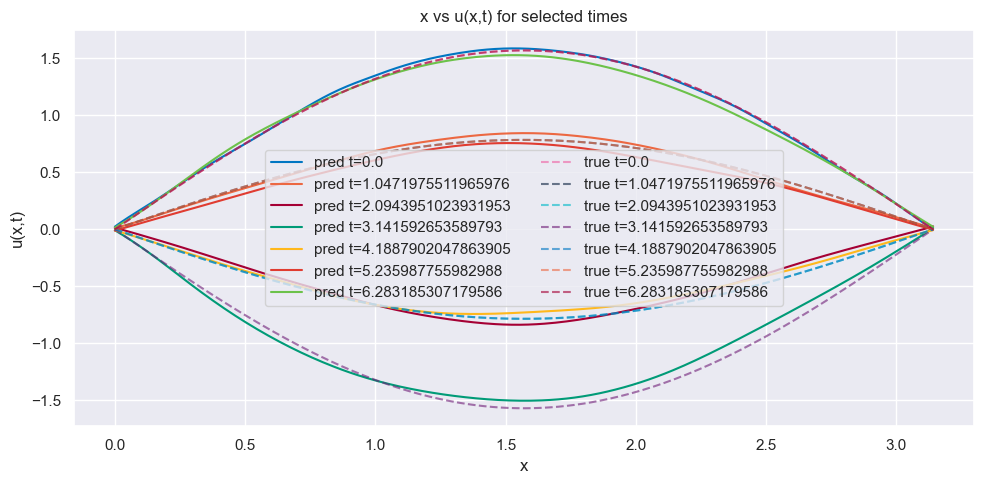

In [23]:
# Plot x vs u(x,t) for multiple time instants using the trained model

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the first for u
            u_pred_output, _ = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm, _ = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u_exact' in globals(): # Changed 'u' to 'u_exact' for clarity
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Calculate the new time points: 0, T_end, and 5 evenly spaced times in between
num_times = 7 # 0, t_end, and 5 in between
new_times = np.linspace(0, t_end, num_times)

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=new_times, Nx =300, L_val=L, with_exact=True)

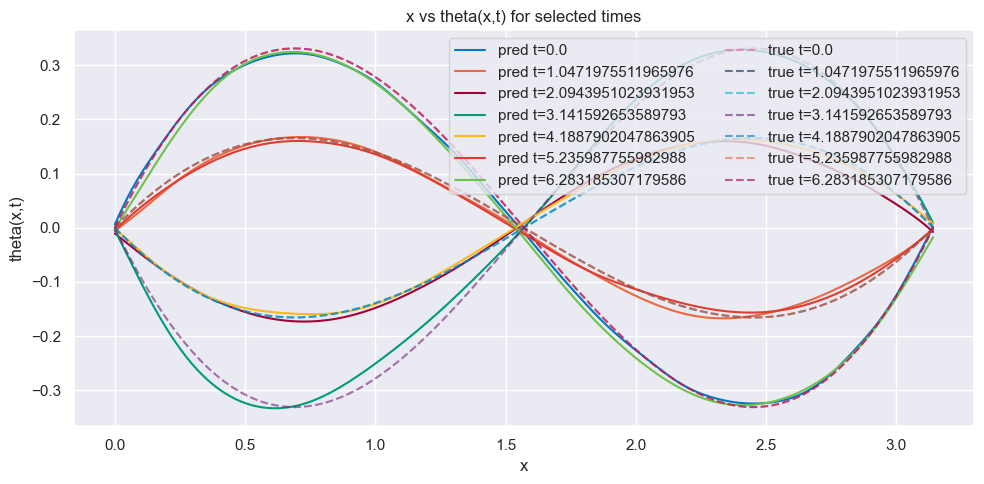

In [24]:
# Plot x vs theta(x,t) for multiple time instants using the trained model

def plot_x_vs_theta_at_times(model, times, Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            '''
            # Model now outputs two values (u, theta), so take the second for theta
            _, theta_pred_output = model(torch.cat([x, t], dim=1)).split(1, dim=-1)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output.squeeze().cpu()))
            '''
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            _, theta_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1)).split(1, dim=-1)
            theta_pred_output_denorm = theta_normalizer.denormalize(theta_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), theta_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, theta_cpu in curves:
        plt.plot(x_cpu.numpy(), theta_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if theta(x,t) is defined above
    if with_exact and 'theta_exact' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            theta_true = theta_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), theta_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('theta(x,t)')
    plt.title('x vs theta(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for theta
plot_x_vs_theta_at_times(pinn, times=new_times, Nx=300, L_val=L, with_exact=True)

In [25]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    out_n = pinn(torch.cat([xg_n, tg_n], dim=1))
    u_n, theta_n = out_n.split(1, dim=-1)

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
theta_pred = theta_normalizer.denormalize(theta_n).cpu().numpy().reshape(Nx, Nt)

u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
theta_true = theta_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)

R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100
R_theta = np.linalg.norm(theta_pred - theta_true) / np.linalg.norm(theta_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")
print(f"Grid relative error (theta): {R_theta:.6f}%")

Grid relative error (u):     2.673239%
Grid relative error (theta): 4.239539%
